In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helpers
import time
import cuml, cudf, cupy

# import preprocessing libraries and metrics
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold, KFold
# from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import statsmodel
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# import models
import xgboost as xgb # XGBoost
# from cuml.linear_model import LinearRegression
# from sklearn.decomposition import PCA # Principal Component Analysis
# from sklearn.linear_model import Lasso 
# from cuml.ensemble import RandomForestRegressor # Random Forest
# from cuml.neighbors import KNeighborsRegressor # K-nearest Neighbors
# from cuml.svm import SVR # Support Vector Regressor
from sklearn.preprocessing import PolynomialFeatures
from catboost import CatBoostRegressor # Catboost
import lightgbm as lgb # Light Gradient-Boosting Machine

# import GPU method
# from cuml.model_selection import train_test_split
from cuml.metrics import mean_absolute_error, mean_squared_error, r2_score
from cuml.linear_model import LinearRegression, Lasso
from cuml import PCA # Principal Component Analysis
from cuml.ensemble import RandomForestRegressor # Random Forest
from cuml.neighbors import KNeighborsRegressor # K-nearest Neighbors
from cuml.svm import SVR # Support Vector Regressor
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


# set plot theme
plt.style.use('ggplot')

# set dataframe display 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10000)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 10000)

In [2]:
# import training data

train_df = pd.read_csv('../data/train.csv')

train_df = helpers.clean_headers(train_df)


print(train_df.head())

  sex  length  diameter  height     weight  shucked_weight  viscera_weight  shell_weight  age
0   I  1.5250    1.1750  0.3750  28.973189       12.728926        6.647958      8.348928    9
1   I  1.1000    0.8250  0.2750  10.418441        4.521745        2.324659      3.401940    8
2   M  1.3875    1.1125  0.3750  24.777463       11.339800        5.556502      6.662133    9
3   F  1.7000    1.4125  0.5000  50.660556       20.354941       10.991839     14.996885   11
4   I  1.2500    1.0125  0.3375  23.289114       11.977664        4.507570      5.953395    8


### Normalizing data

We will normalize the ranges of numerical variables using `StandardScaler()` and categotical variables with `OneHotEncoder()`. The target variable will not be scaled. 

In [3]:
# normalize numerical variables and one hot encode categorical variables

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['length', 'diameter', 'height', 'weight','shucked_weight', 'viscera_weight', 'shell_weight']),
        ('cat', OneHotEncoder(), ['sex'])
    ]
)

# apply transformations
scaled_data = preprocessor.fit_transform(train_df)

# get column headers
column_names = preprocessor.get_feature_names_out()

# Convert transformed data back to Dataframe
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

scaled_df['age'] = train_df['age']

print(scaled_df.head()) # debug

   num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M  age
0     0.721238       0.633982     0.292400     0.441804             0.467188             0.569186           0.453376         0.0         1.0         0.0    9
1    -0.755712      -0.840356    -0.794163    -1.025198            -0.993688            -0.978880          -0.926788         0.0         1.0         0.0    8
2     0.243401       0.370707     0.292400     0.110076             0.219924             0.178363          -0.017224         0.0         0.0         1.0    9
3     1.329394       1.634426     1.650603     2.156483             1.824616             2.124622           2.308095         1.0         0.0         0.0   11
4    -0.234435      -0.050532    -0.115061    -0.007598             0.333464            -0.197233          -0.214955         0.0         1.0         0.0    8


## Checking for Multicollinearity

In [4]:
# Checking for multicollinearity



# Add a constant term for the intercept
X_with_constant = add_constant(train_df.iloc[:,1:])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X_with_constant.columns
vif["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

print(vif)

         Variable        VIF
0           const  75.590550
1          length  50.036365
2        diameter  52.355138
3          height   7.811277
4          weight  78.053036
5  shucked_weight  25.301892
6  viscera_weight  17.968955
7    shell_weight  20.997071
8             age   2.170267


The Variance Inflation Factor (VIF) is a measure of the amount of multicollinearity in regression analysis. This can be interpreted as follows:

- VIF equals to 1: variables are not correlated
- 1 < VIF < 5: variables are moderetely correlated
- VIF > 5: Variables are highly correlated

With the above references, we can see that the variables in our dataframe have high multicollinearity and needs to be addressed. 

## Address Multicollinearity 1: Feature Engineer

Here, we aim to combined independent variables to combine the interactions terms between independent variables. 

In [5]:
### Feature Engineering

featured_df = train_df.copy()

# ratio of shell weight to entire weight
featured_df['shell_weight_ratio'] = featured_df['shell_weight'] / featured_df['weight']

# meat yield
featured_df['shucked_weight_ratio'] = featured_df['shucked_weight'] / featured_df['weight']

# ratio of viscera weight to shucked weight
featured_df['vis_shucked_weight_ratio'] = featured_df['viscera_weight'] / featured_df['shucked_weight']

# General Surface Area
featured_df['surface_area'] = np.pi * 0.5 * featured_df['length'] * 0.5 * featured_df['diameter'] 




featured_df = featured_df.drop(columns = ['weight', 'length',  'diameter'
                                    ,'shucked_weight', 'viscera_weight', 'shell_weight'])

print(featured_df.head())

  sex  height  age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
0   I  0.3750    9            0.288160              0.439335                  0.522272      1.407335
1   I  0.2750    8            0.326531              0.434014                  0.514107      0.712749
2   M  0.3750    9            0.268879              0.457666                  0.490000      1.212336
3   F  0.5000   11            0.296027              0.401791                  0.540008      1.885937
4   I  0.3375    8            0.255630              0.514303                  0.376331      0.994020


In [6]:
# Checking for MULTICOLLINEARITY

# Add a constant term for the intercept
X_with_constant = add_constant(featured_df.iloc[:,1:])

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["Variable"] = X_with_constant.columns
vif["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

print(vif)

                   Variable         VIF
0                     const  190.904621
1                    height    6.716363
2                       age    1.924998
3        shell_weight_ratio    1.191649
4      shucked_weight_ratio    1.355263
5  vis_shucked_weight_ratio    1.371334
6              surface_area    6.773995


We have acceptable values for VIF for the feature engineered variables

In [7]:
print(featured_df.head())

  sex  height  age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
0   I  0.3750    9            0.288160              0.439335                  0.522272      1.407335
1   I  0.2750    8            0.326531              0.434014                  0.514107      0.712749
2   M  0.3750    9            0.268879              0.457666                  0.490000      1.212336
3   F  0.5000   11            0.296027              0.401791                  0.540008      1.885937
4   I  0.3375    8            0.255630              0.514303                  0.376331      0.994020


In [8]:
print(featured_df.describe())

             height           age  shell_weight_ratio  shucked_weight_ratio  vis_shucked_weight_ratio  surface_area
count  74051.000000  74051.000000        74051.000000          74051.000000              74051.000000  74051.000000
mean       0.348089      9.967806            0.292896              0.431529                  0.511358      1.113163
std        0.092034      3.175189            0.040047              0.078134                  0.096185      0.436149
min        0.000000      1.000000            0.075472              0.083333                  0.025253      0.020249
25%        0.300000      8.000000            0.267640              0.398569                  0.447483      0.807487
50%        0.362500     10.000000            0.288903              0.432212                  0.501779      1.174416
75%        0.412500     11.000000            0.314214              0.463571                  0.564616      1.449060
max        2.825000     29.000000            2.615672              4.725

In [9]:
# Scale the variables

preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), ['shell_weight_ratio', 'shucked_weight_ratio', 'vis_shucked_weight_ratio', 'surface_area']),
        ('cat', OneHotEncoder(), ['sex'])
        
    ]
)

X_preprocessed = preprocessor.fit_transform(featured_df)

# get column headers
column_headers = preprocessor.get_feature_names_out()


# convert transformed data back to dataframe
preprocessed_df = pd.DataFrame(X_preprocessed, columns=column_headers)
preprocessed_df['age'] = featured_df['age']


In [10]:
# check datatype for preprocessed data

# print(preprocessed_df.dtypes) # visual check

# convert data type to float32 for efficient use and RAPIDS ecosystem compatibility

columns = preprocessed_df.columns.to_list()

for col in columns:
    preprocessed_df[col] = preprocessed_df[col].astype('float32')

print(preprocessed_df.dtypes) # final check

num__shell_weight_ratio          float32
num__shucked_weight_ratio        float32
num__vis_shucked_weight_ratio    float32
num__surface_area                float32
cat__sex_F                       float32
cat__sex_I                       float32
cat__sex_M                       float32
age                              float32
dtype: object


---

In [11]:
#########################################
# GPU
#########################################

# convert to GPU compatible dataframe

# # convert Pandas DF to CuPy array
# cupy_array = cupy.array(preprocessed_df.values)

# # Create a cuDF DF from CuPy array
# cudf_df = cudf.DataFrame(cupy_array, columns = preprocessed_df.columns)


# # Split the variables between independent and target variable
y_preprocessed = preprocessed_df['age']
X_preprocessed = preprocessed_df.drop(columns = ['age'])


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42)

In [12]:
compiled_scores = {}

In [13]:
def get_scores(model, score_dict):

    
    # predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

   

    # MAE
    mae_train = float(mean_absolute_error(y_train, y_pred_train))
    mae_test = float(mean_absolute_error(y_test, y_pred_test))

    # MSE
    mse_train = float(mean_squared_error(y_train, y_pred_train))
    mse_test = float(mean_squared_error(y_test, y_pred_test))

    # R2
    r2_train = float(r2_score(y_train, y_pred_train))
    r2_test = float(r2_score(y_test, y_pred_test))

    print(f'''
    {str('-')*20}
    Performance Metrics: {model}
    {str('-')*20}
        
    Mean Absolute Error (train): {mae_train:.4f}
    Mean Absolute Error (test): {mae_test:.4f}

    {str('-')*50}

    Mean Squared Error (train): {mse_train:.4f}
    Mean Squared Error (test): {mse_test:.4f}

    {str('-')*50}

    Coefficient of Determination (R2) (train): {r2_train:.4f}
    Coefficient of Determination (R2) (test): {r2_test:.4f}

    {str('-')*50}

    ''')

    # add to compiled scores dict
    score_dict[str(model)] = {'MAE Train': mae_train,
                              'MAE Test': mae_test,
                              'MSE Train': mse_train,
                              'MSE Test': mse_test,
                              'R2 Train': r2_train,
                              'R2 Test': r2_test}
    
    # return compiled_scores


In [16]:
# Linear Regression
linreg = LinearRegression(copy_X = True)

linreg = linreg.fit(X_train, y_train)


get_scores(linreg, compiled_scores)



    --------------------
    Performance Metrics: LinearRegression()
    --------------------
        
    Mean Absolute Error (train): 1.6146
    Mean Absolute Error (test): 1.6275

    --------------------------------------------------

    Mean Squared Error (train): 5.3123
    Mean Squared Error (test): 5.4490

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.4716
    Coefficient of Determination (R2) (test): 0.4653

    --------------------------------------------------

    


In [17]:
# Lasso Regression

lasso_model = Lasso(alpha=0.5)

lasso_model.fit(X_train, y_train)

get_scores(lasso_model, compiled_scores)


    --------------------
    Performance Metrics: Lasso()
    --------------------
        
    Mean Absolute Error (train): 1.8032
    Mean Absolute Error (test): 1.8160

    --------------------------------------------------

    Mean Squared Error (train): 6.3234
    Mean Squared Error (test): 6.4050

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.3711
    Coefficient of Determination (R2) (test): 0.3715

    --------------------------------------------------

    


In [18]:
%%time
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_train, y_train)

get_scores(rf_model, compiled_scores)


    --------------------
    Performance Metrics: RandomForestRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.3978
    Mean Absolute Error (test): 1.4040

    --------------------------------------------------

    Mean Squared Error (train): 3.9970
    Mean Squared Error (test): 3.9896

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6025
    Coefficient of Determination (R2) (test): 0.6085

    --------------------------------------------------

    
CPU times: user 7.49 s, sys: 1.67 s, total: 9.16 s
Wall time: 1.87 s


In [19]:
%%time

# K Nearest Neighbours

knn = KNeighborsRegressor()

knn_model = knn.fit(X_train, y_train)

get_scores(knn, compiled_scores)


    --------------------
    Performance Metrics: KNeighborsRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.2929
    Mean Absolute Error (test): 1.5824

    --------------------------------------------------

    Mean Squared Error (train): 3.4736
    Mean Squared Error (test): 5.1886

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6545
    Coefficient of Determination (R2) (test): 0.4909

    --------------------------------------------------

    
CPU times: user 243 ms, sys: 29.1 ms, total: 272 ms
Wall time: 276 ms


In [20]:
%%time

svr = SVR()

svr_model = svr.fit(X_train, y_train)

get_scores(svr_model, compiled_scores)


    --------------------
    Performance Metrics: SVR()
    --------------------
        
    Mean Absolute Error (train): 1.3948
    Mean Absolute Error (test): 1.4073

    --------------------------------------------------

    Mean Squared Error (train): 4.5301
    Mean Squared Error (test): 4.5634

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.5494
    Coefficient of Determination (R2) (test): 0.5522

    --------------------------------------------------

    
CPU times: user 2.65 s, sys: 974 ms, total: 3.62 s
Wall time: 3.69 s


In [21]:
%%time

# Catboost

cat = CatBoostRegressor(task_type = 'GPU',
                        iterations = 1000,
                        learning_rate = 0.1,
                        verbose = False)

cat_model = cat.fit(X_train, y_train)

get_scores(cat_model, compiled_scores)


    --------------------
    Performance Metrics: <catboost.core.CatBoostRegressor object at 0x7efce2bb7670>
    --------------------
        
    Mean Absolute Error (train): 1.3653
    Mean Absolute Error (test): 1.4515

    --------------------------------------------------

    Mean Squared Error (train): 3.8477
    Mean Squared Error (test): 4.4276

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6173
    Coefficient of Determination (R2) (test): 0.5656

    --------------------------------------------------

    
CPU times: user 10.4 s, sys: 3.86 s, total: 14.3 s
Wall time: 9.09 s


In [22]:
%%time

# XGBoost

xgb_model = xgb.XGBRegressor(
            device = 'cuda',  # Using GPU
            booster = 'gbtree',
            random_state=42
            )

xgb_model = xgb_model.fit(X_train, y_train)

get_scores(xgb_model, compiled_scores)


    --------------------
    Performance Metrics: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
    --------------------
        
    Mean Absolute Error (train): 1.3019
    Mean Absolute Error (test): 1.4704

    --------------------------------------------------

    Mean Squared Error (trai

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:27:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [23]:
compiled_scores_df = pd.DataFrame(compiled_scores)

list_of_models = ['Linear Regression', 'Lasso Regression', 'Random Forest', 'K-Nearest Neighbours',
                  'Support Vector Machine', 'Catboost', 'XGBoost']

# rename the name of models in df
compiled_scores_df.columns = list_of_models[:len(compiled_scores_df.columns)]

print(compiled_scores_df)
    

           Linear Regression  Lasso Regression  Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost   XGBoost
MAE Train           1.614606          1.803177       1.397774              1.292866                1.394762  1.365251  1.301911
MAE Test            1.627452          1.816045       1.403963              1.582378                1.407256  1.451547  1.470403
MSE Train           5.312345          6.323436       3.996969              3.473632                4.530117  3.847694  3.477865
MSE Test            5.449029          6.405003       3.989578              5.188632                4.563356  4.427625  4.541707
R2 Train            0.471629          0.371065       0.602457              0.654509                0.549430  0.617304  0.654088
R2 Test             0.465339          0.371539       0.608541              0.490889                0.552242  0.565560  0.554366


In [22]:
%%time

# convert to GPU compatible dataframe

# # convert Pandas DF to CuPy array
cupy_array = cupy.array(preprocessed_df.values)

# Create a cuDF DF from CuPy array
cudf_df = cudf.DataFrame(cupy_array, columns = preprocessed_df.columns)

# # Split the variables between independent and target variable
y_cudf = cudf_df['age']
X_cudf = cudf_df.drop(columns = ['age'])

# Conversion to DMatrix
def convert_to_dmatrix(X, y):
    return xgb.DMatrix(data=X, label=y)

# Define the objective function
def objective(space):
    mae_scores = []
    try: 
        # K-Fold Cross-Validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        
        for train_index, test_index in kf.split(X_cudf):
            X_train, X_test = X_cudf.iloc[train_index], X_cudf.iloc[test_index]
            y_train, y_test = y_cudf.iloc[train_index], y_cudf.iloc[test_index]
            
            dtrain = convert_to_dmatrix(X_train, y_train)
            dtest = convert_to_dmatrix(X_test, y_test)
            
            params = {
                'max_depth': int(space['max_depth']),
                'gamma': space['gamma'],
                'subsample': space['subsample'],
                'eta': space['eta'],
                'min_child_weight': space['min_child_weight'],
                'device': 'cuda',                                # state GPU
                'objective': 'reg:squarederror',
                'eval_metric': 'mae'
            }
            
            model = xgb.train(params, dtrain, evals=[(dtrain, 'train')], num_boost_round=100)
            preds = model.predict(dtest)

            # # Convert y_test to numpy array correctly
            # if isinstance(y_test, cudf.Series):
            #     y_test_array = y_test.to_numpy()  # or y_test.values_host for newer versions
            # else:
            #     y_test_array = y_test.to_numpy()  # pandas case

            # mae = mean_absolute_error(y_test_array, preds)
            mae = mean_absolute_error(y_test, preds)
            mae_scores.append(mae)
        
        # average_mae = np.mean(mae_scores)
        mae_scores_gpu = cupy.array(mae_scores)
        average_mae = cupy.mean(mae_scores_gpu).get()
        return {'loss': average_mae, 'status': STATUS_OK}
    
    except Exception as e:
        print(f"Error with parameters {space}: {str(e)}")
        return {'loss': float('inf'), 'status': STATUS_FAIL}  # Use a large loss to denote failure

# Hyperparameter space
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0.0, 0.5),
    'eta': hp.uniform('eta', 0.01, 0.3)
}

# Optimization Algorithm
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=50,  # Change as per computational resources
            trials=trials)

print("Best hyperparameters:", best)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

[0]	train-mae:2.24771                                 
[1]	train-mae:2.18465                                 
[2]	train-mae:2.12486                                 
[3]	train-mae:2.06976                                 
[4]	train-mae:2.01818                                 
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.96967                                 
[6]	train-mae:1.92701                                 
[7]	train-mae:1.88685                                 
[8]	train-mae:1.85003                                 
[9]	train-mae:1.81505                                 
[10]	train-mae:1.78351                                
[11]	train-mae:1.75440                                
[12]	train-mae:1.72769                                
[13]	train-mae:1.70388                                
[14]	train-mae:1.68137                                
[15]	train-mae:1.66119                                
[16]	train-mae:1.64253                                
[17]	train-mae:1.62516                                
[18]	train-mae:1.60925                                
[19]	train-mae:1.59475                                
[20]	train-mae:1.58187                                
[21]	train-mae:1.56977                                
[22]	train-mae:1.55882                                
[23]	train

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.81899                                 
[10]	train-mae:1.78716                                
[11]	train-mae:1.75832                                
[12]	train-mae:1.73066                                
[13]	train-mae:1.70603                                
[14]	train-mae:1.68325                                
[15]	train-mae:1.66323                                
[16]	train-mae:1.64481                                
[17]	train-mae:1.62796                                
[18]	train-mae:1.61247                                
[19]	train-mae:1.59827                                
[20]	train-mae:1.58530                                
[21]	train-mae:1.57336                                
[22]	train-mae:1.56176                                
[23]	train-mae:1.55135                                
[24]	train-mae:1.54171                                
[25]	train-mae:1.53259                                
[26]	train-mae:1.52436                                
[27]	train

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:2.02819                                 
[5]	train-mae:1.97917                                 
[6]	train-mae:1.93585                                 
[7]	train-mae:1.89499                                 
[8]	train-mae:1.85754                                 
[9]	train-mae:1.82270                                 
[10]	train-mae:1.79030                                
[11]	train-mae:1.76143                                
[12]	train-mae:1.73454                                
[13]	train-mae:1.71021                                
[14]	train-mae:1.68830                                
[15]	train-mae:1.66760                                
[16]	train-mae:1.64944                                
[17]	train-mae:1.63236                                
[18]	train-mae:1.61684                                
[19]	train-mae:1.60232                                
[20]	train-mae:1.58876                                
[21]	train-mae:1.57629                                
[22]	train

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.87679                                 
[8]	train-mae:1.83957                                 
[9]	train-mae:1.80479                                 
[10]	train-mae:1.77272                                
[11]	train-mae:1.74388                                
[12]	train-mae:1.71792                                
[13]	train-mae:1.69375                                
[14]	train-mae:1.67113                                
[15]	train-mae:1.65108                                
[16]	train-mae:1.63213                                
[17]	train-mae:1.61568                                
[18]	train-mae:1.60018                                
[19]	train-mae:1.58571                                
[20]	train-mae:1.57287                                
[21]	train-mae:1.56091                                
[22]	train-mae:1.55003                                
[23]	train-mae:1.53949                                
[24]	train-mae:1.52972                                
[25]	train

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.89350                                 
[8]	train-mae:1.85640                                 
[9]	train-mae:1.82234                                 
[10]	train-mae:1.79036                                
[11]	train-mae:1.76125                                
[12]	train-mae:1.73375                                
[13]	train-mae:1.70975                                
[14]	train-mae:1.68756                                
[15]	train-mae:1.66680                                
[16]	train-mae:1.64858                                
[17]	train-mae:1.63140                                
[18]	train-mae:1.61586                                
[19]	train-mae:1.60160                                
[20]	train-mae:1.58797                                
[21]	train-mae:1.57585                                
[22]	train-mae:1.56448                                
[23]	train-mae:1.55408                                
[24]	train-mae:1.54392                                
[25]	train

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.47009
[5]	train-mae:1.43268                                                         
[6]	train-mae:1.40938                                                         
[7]	train-mae:1.39586                                                         
[8]	train-mae:1.38618                                                         
[9]	train-mae:1.37854                                                         
[10]	train-mae:1.37212                                                        
[11]	train-mae:1.36749                                                        
[12]	train-mae:1.36495                                                        
[13]	train-mae:1.36097                                                        
[14]	train-mae:1.35692                                                        
[15]	train-mae:1.35321                                                        
[16]	train-mae:1.35050                                                        
[17]	train-mae:1.34775        

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.43521                                                         
[6]	train-mae:1.41175                                                         
[7]	train-mae:1.39736                                                         
[8]	train-mae:1.38811                                                         
[9]	train-mae:1.38077                                                         
[10]	train-mae:1.37596                                                        
[11]	train-mae:1.37101                                                        
[12]	train-mae:1.36790                                                        
[13]	train-mae:1.36400                                                        
[14]	train-mae:1.36058                                                        
[15]	train-mae:1.35734                                                        
[16]	train-mae:1.35428                                                        
[17]	train-mae:1.34979                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.44117                                                         
[6]	train-mae:1.41685                                                         
[7]	train-mae:1.40107                                                         
[8]	train-mae:1.39077                                                         
[9]	train-mae:1.38291                                                         
[10]	train-mae:1.37726                                                        
[11]	train-mae:1.37215                                                        
[12]	train-mae:1.36857                                                        
[13]	train-mae:1.36441                                                        
[14]	train-mae:1.36078                                                        
[15]	train-mae:1.35569                                                        
[16]	train-mae:1.35317                                                        
[17]	train-mae:1.34963                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.42414                                                         
[6]	train-mae:1.40159                                                         
[7]	train-mae:1.38816                                                         
[8]	train-mae:1.37861                                                         
[9]	train-mae:1.37178                                                         
[10]	train-mae:1.36609                                                        
[11]	train-mae:1.36098                                                        
[12]	train-mae:1.35726                                                        
[13]	train-mae:1.35398                                                        
[14]	train-mae:1.34969                                                        
[15]	train-mae:1.34638                                                        
[16]	train-mae:1.34170                                                        
[17]	train-mae:1.33671                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:1.41482                                                         
[7]	train-mae:1.39968                                                         
[8]	train-mae:1.39004                                                         
[9]	train-mae:1.38290                                                         
[10]	train-mae:1.37815                                                        
[11]	train-mae:1.37333                                                        
[12]	train-mae:1.36921                                                        
[13]	train-mae:1.36513                                                        
[14]	train-mae:1.36225                                                        
[15]	train-mae:1.35915                                                        
[16]	train-mae:1.35487                                                        
[17]	train-mae:1.35210                                                        
[18]	train-mae:1.34902                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:2.09041                                                         
[5]	train-mae:2.05100                                                         
[6]	train-mae:2.01332                                                         
[7]	train-mae:1.97778                                                         
[8]	train-mae:1.94392                                                         
[9]	train-mae:1.91217                                                         
[10]	train-mae:1.88174                                                        
[11]	train-mae:1.85332                                                        
[12]	train-mae:1.82634                                                        
[13]	train-mae:1.80057                                                        
[14]	train-mae:1.77616                                                        
[15]	train-mae:1.75330                                                        
[16]	train-mae:1.73151                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:2.05570                                                         
[6]	train-mae:2.01775                                                         
[7]	train-mae:1.98157                                                         
[8]	train-mae:1.94754                                                         
[9]	train-mae:1.91500                                                         
[10]	train-mae:1.88450                                                        
[11]	train-mae:1.85531                                                        
[12]	train-mae:1.82798                                                        
[13]	train-mae:1.80190                                                        
[14]	train-mae:1.77721                                                        
[15]	train-mae:1.75395                                                        
[16]	train-mae:1.73216                                                        
[17]	train-mae:1.71151                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.95326                                                         
[9]	train-mae:1.92051                                                         
[10]	train-mae:1.88967                                                        
[11]	train-mae:1.86085                                                        
[12]	train-mae:1.83334                                                        
[13]	train-mae:1.80724                                                        
[14]	train-mae:1.78269                                                        
[15]	train-mae:1.75959                                                        
[16]	train-mae:1.73787                                                        
[17]	train-mae:1.71713                                                        
[18]	train-mae:1.69759                                                        
[19]	train-mae:1.67912                                                        
[20]	train-mae:1.66151                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.96692                                                         
[8]	train-mae:1.93290                                                         
[9]	train-mae:1.90096                                                         
[10]	train-mae:1.87053                                                        
[11]	train-mae:1.84183                                                        
[12]	train-mae:1.81476                                                        
[13]	train-mae:1.78903                                                        
[14]	train-mae:1.76461                                                        
[15]	train-mae:1.74156                                                        
[16]	train-mae:1.71992                                                        
[17]	train-mae:1.69932                                                        
[18]	train-mae:1.68002                                                        
[19]	train-mae:1.66193                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:2.05836                                                         
[6]	train-mae:2.02060                                                         
[7]	train-mae:1.98465                                                         
[8]	train-mae:1.95037                                                         
[9]	train-mae:1.91806                                                         
[10]	train-mae:1.88743                                                        
[11]	train-mae:1.85840                                                        
[12]	train-mae:1.83109                                                        
[13]	train-mae:1.80543                                                        
[14]	train-mae:1.78098                                                        
[15]	train-mae:1.75790                                                        
[16]	train-mae:1.73627                                                        
[17]	train-mae:1.71548                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.47718
[13]	train-mae:1.46630                                                        
[14]	train-mae:1.45710                                                        
[15]	train-mae:1.45040                                                        
[16]	train-mae:1.44467                                                        
[17]	train-mae:1.44028                                                        
[18]	train-mae:1.43682                                                        
[19]	train-mae:1.43348                                                        
[20]	train-mae:1.43118                                                        
[21]	train-mae:1.42857                                                        
[22]	train-mae:1.42700                                                        
[23]	train-mae:1.42539                                                        
[24]	train-mae:1.42419                                                        
[25]	train-mae:1.42315       

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.49327                                                        
[12]	train-mae:1.47960                                                        
[13]	train-mae:1.46808                                                        
[14]	train-mae:1.45869                                                        
[15]	train-mae:1.45208                                                        
[16]	train-mae:1.44674                                                        
[17]	train-mae:1.44189                                                        
[18]	train-mae:1.43873                                                        
[19]	train-mae:1.43572                                                        
[20]	train-mae:1.43336                                                        
[21]	train-mae:1.43152                                                        
[22]	train-mae:1.42989                                                        
[23]	train-mae:1.42837                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.53439
[10]	train-mae:1.51334                                                        
[11]	train-mae:1.49603                                                        
[12]	train-mae:1.48211                                                        
[13]	train-mae:1.47100                                                        
[14]	train-mae:1.46176                                                        
[15]	train-mae:1.45505                                                        
[16]	train-mae:1.44997                                                        
[17]	train-mae:1.44529                                                        
[18]	train-mae:1.44156                                                        
[19]	train-mae:1.43875                                                        
[20]	train-mae:1.43597                                                        
[21]	train-mae:1.43390                                                        
[22]	train-mae:1.43243        

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.46773                                                        
[13]	train-mae:1.45665                                                        
[14]	train-mae:1.44709                                                        
[15]	train-mae:1.44066                                                        
[16]	train-mae:1.43566                                                        
[17]	train-mae:1.43172                                                        
[18]	train-mae:1.42842                                                        
[19]	train-mae:1.42514                                                        
[20]	train-mae:1.42275                                                        
[21]	train-mae:1.42099                                                        
[22]	train-mae:1.41905                                                        
[23]	train-mae:1.41774                                                        
[24]	train-mae:1.41647                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.56094                                                         
[9]	train-mae:1.53539                                                         
[10]	train-mae:1.51433                                                        
[11]	train-mae:1.49721                                                        
[12]	train-mae:1.48281                                                        
[13]	train-mae:1.47206                                                        
[14]	train-mae:1.46281                                                        
[15]	train-mae:1.45551                                                        
[16]	train-mae:1.44993                                                        
[17]	train-mae:1.44566                                                        
[18]	train-mae:1.44256                                                        
[19]	train-mae:1.43984                                                        
[20]	train-mae:1.43778                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.59273                                                         
[5]	train-mae:1.52578                                                         
[6]	train-mae:1.47405                                                         
[7]	train-mae:1.43328                                                         
[8]	train-mae:1.40126                                                         
[9]	train-mae:1.37583                                                         
[10]	train-mae:1.35442                                                        
[11]	train-mae:1.33770                                                        
[12]	train-mae:1.32437                                                        
[13]	train-mae:1.31295                                                        
[14]	train-mae:1.30323                                                        
[15]	train-mae:1.29430                                                        
[16]	train-mae:1.28719                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:1.67622                                                         
[4]	train-mae:1.59091                                                         
[5]	train-mae:1.52444                                                         
[6]	train-mae:1.47241                                                         
[7]	train-mae:1.43143                                                         
[8]	train-mae:1.39864                                                         
[9]	train-mae:1.37250                                                         
[10]	train-mae:1.35222                                                        
[11]	train-mae:1.33438                                                        
[12]	train-mae:1.32069                                                        
[13]	train-mae:1.30994                                                        
[14]	train-mae:1.30014                                                        
[15]	train-mae:1.29237                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:1.68208                                                         
[4]	train-mae:1.59680                                                         
[5]	train-mae:1.53032                                                         
[6]	train-mae:1.47799                                                         
[7]	train-mae:1.43712                                                         
[8]	train-mae:1.40383                                                         
[9]	train-mae:1.37675                                                         
[10]	train-mae:1.35638                                                        
[11]	train-mae:1.33991                                                        
[12]	train-mae:1.32631                                                        
[13]	train-mae:1.31573                                                        
[14]	train-mae:1.30645                                                        
[15]	train-mae:1.29914                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:1.66404                                                         
[4]	train-mae:1.57898                                                         
[5]	train-mae:1.51342                                                         
[6]	train-mae:1.46119                                                         
[7]	train-mae:1.42073                                                         
[8]	train-mae:1.38847                                                         
[9]	train-mae:1.36266                                                         
[10]	train-mae:1.34239                                                        
[11]	train-mae:1.32568                                                        
[12]	train-mae:1.31328                                                        
[13]	train-mae:1.30269                                                        
[14]	train-mae:1.29298                                                        
[15]	train-mae:1.28555                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.59368                                                         
[5]	train-mae:1.52663                                                         
[6]	train-mae:1.47481                                                         
[7]	train-mae:1.43411                                                         
[8]	train-mae:1.40103                                                         
[9]	train-mae:1.37576                                                         
[10]	train-mae:1.35401                                                        
[11]	train-mae:1.33728                                                        
[12]	train-mae:1.32501                                                        
[13]	train-mae:1.31472                                                        
[14]	train-mae:1.30463                                                        
[15]	train-mae:1.29683                                                        
[16]	train-mae:1.29054                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.46451                                                        
[11]	train-mae:1.45605                                                        
[12]	train-mae:1.45022                                                        
[13]	train-mae:1.44529                                                        
[14]	train-mae:1.44177                                                        
[15]	train-mae:1.43935                                                        
[16]	train-mae:1.43700                                                        
[17]	train-mae:1.43568                                                        
[18]	train-mae:1.43496                                                        
[19]	train-mae:1.43431                                                        
[20]	train-mae:1.43339                                                        
[21]	train-mae:1.43223                                                        
[22]	train-mae:1.43198                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.46101                                                        
[12]	train-mae:1.45574                                                        
[13]	train-mae:1.45119                                                        
[14]	train-mae:1.44792                                                        
[15]	train-mae:1.44534                                                        
[16]	train-mae:1.44345                                                        
[17]	train-mae:1.44226                                                        
[18]	train-mae:1.44122                                                        
[19]	train-mae:1.43926                                                        
[20]	train-mae:1.43800                                                        
[21]	train-mae:1.43681                                                        
[22]	train-mae:1.43572                                                        
[23]	train-mae:1.43505                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.46498                                                        
[12]	train-mae:1.45840                                                        
[13]	train-mae:1.45310                                                        
[14]	train-mae:1.44911                                                        
[15]	train-mae:1.44662                                                        
[16]	train-mae:1.44496                                                        
[17]	train-mae:1.44372                                                        
[18]	train-mae:1.44249                                                        
[19]	train-mae:1.44142                                                        
[20]	train-mae:1.44018                                                        
[21]	train-mae:1.43936                                                        
[22]	train-mae:1.43831                                                        
[23]	train-mae:1.43775                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.44088                                                        
[14]	train-mae:1.43712                                                        
[15]	train-mae:1.43508                                                        
[16]	train-mae:1.43254                                                        
[17]	train-mae:1.43138                                                        
[18]	train-mae:1.43050                                                        
[19]	train-mae:1.42880                                                        
[20]	train-mae:1.42811                                                        
[21]	train-mae:1.42700                                                        
[22]	train-mae:1.42643                                                        
[23]	train-mae:1.42567                                                        
[24]	train-mae:1.42488                                                        
[25]	train-mae:1.42415                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.45621                                                        
[13]	train-mae:1.45337                                                        
[14]	train-mae:1.45018                                                        
[15]	train-mae:1.44712                                                        
[16]	train-mae:1.44514                                                        
[17]	train-mae:1.44438                                                        
[18]	train-mae:1.44288                                                        
[19]	train-mae:1.44212                                                        
[20]	train-mae:1.44119                                                        
[21]	train-mae:1.44001                                                        
[22]	train-mae:1.43937                                                        
[23]	train-mae:1.43866                                                        
[24]	train-mae:1.43815                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.88300                                                         
[5]	train-mae:1.82138                                                         
[6]	train-mae:1.76643                                                         
[7]	train-mae:1.71766                                                         
[8]	train-mae:1.67401                                                         
[9]	train-mae:1.63599                                                         
[10]	train-mae:1.60136                                                        
[11]	train-mae:1.57085                                                        
[12]	train-mae:1.54399                                                        
[13]	train-mae:1.52072                                                        
[14]	train-mae:1.49972                                                        
[15]	train-mae:1.48137                                                        
[16]	train-mae:1.46460                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.82408                                                         
[6]	train-mae:1.76823                                                         
[7]	train-mae:1.71883                                                         
[8]	train-mae:1.67559                                                         
[9]	train-mae:1.63713                                                         
[10]	train-mae:1.60301                                                        
[11]	train-mae:1.57233                                                        
[12]	train-mae:1.54503                                                        
[13]	train-mae:1.52145                                                        
[14]	train-mae:1.50026                                                        
[15]	train-mae:1.48193                                                        
[16]	train-mae:1.46490                                                        
[17]	train-mae:1.45008                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.89221                                                         
[5]	train-mae:1.82931                                                         
[6]	train-mae:1.77316                                                         
[7]	train-mae:1.72383                                                         
[8]	train-mae:1.68019                                                         
[9]	train-mae:1.64124                                                         
[10]	train-mae:1.60683                                                        
[11]	train-mae:1.57706                                                        
[12]	train-mae:1.55053                                                        
[13]	train-mae:1.52653                                                        
[14]	train-mae:1.50520                                                        
[15]	train-mae:1.48639                                                        
[16]	train-mae:1.46976                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.81006                                                         
[6]	train-mae:1.75435                                                         
[7]	train-mae:1.70595                                                         
[8]	train-mae:1.66294                                                         
[9]	train-mae:1.62464                                                         
[10]	train-mae:1.58993                                                        
[11]	train-mae:1.55974                                                        
[12]	train-mae:1.53327                                                        
[13]	train-mae:1.50975                                                        
[14]	train-mae:1.48847                                                        
[15]	train-mae:1.47006                                                        
[16]	train-mae:1.45326                                                        
[17]	train-mae:1.43892                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:1.95998
[4]	train-mae:1.88940                                                         
[5]	train-mae:1.82704                                                         
[6]	train-mae:1.77172                                                         
[7]	train-mae:1.72219                                                         
[8]	train-mae:1.67809                                                         
[9]	train-mae:1.63912                                                         
[10]	train-mae:1.60485                                                        
[11]	train-mae:1.57468                                                        
[12]	train-mae:1.54800                                                        
[13]	train-mae:1.52495                                                        
[14]	train-mae:1.50394                                                        
[15]	train-mae:1.48542                                                        
[16]	train-mae:1.46895        

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:2.16510                                                         
[6]	train-mae:2.14201                                                         
[7]	train-mae:2.11939                                                         
[8]	train-mae:2.09719                                                         
[9]	train-mae:2.07559                                                         
[10]	train-mae:2.05431                                                        
[11]	train-mae:2.03360                                                        
[12]	train-mae:2.01345                                                        
[13]	train-mae:1.99381                                                        
[14]	train-mae:1.97473                                                        
[15]	train-mae:1.95639                                                        
[16]	train-mae:1.93836                                                        
[17]	train-mae:1.92084                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:2.19446                                                         
[5]	train-mae:2.17075                                                         
[6]	train-mae:2.14733                                                         
[7]	train-mae:2.12440                                                         
[8]	train-mae:2.10217                                                         
[9]	train-mae:2.08037                                                         
[10]	train-mae:2.05901                                                        
[11]	train-mae:2.03804                                                        
[12]	train-mae:2.01764                                                        
[13]	train-mae:1.99795                                                        
[14]	train-mae:1.97870                                                        
[15]	train-mae:1.96016                                                        
[16]	train-mae:1.94196                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:2.17743                                                         
[6]	train-mae:2.15390                                                         
[7]	train-mae:2.13084                                                         
[8]	train-mae:2.10852                                                         
[9]	train-mae:2.08639                                                         
[10]	train-mae:2.06498                                                        
[11]	train-mae:2.04425                                                        
[12]	train-mae:2.02387                                                        
[13]	train-mae:2.00394                                                        
[14]	train-mae:1.98450                                                        
[15]	train-mae:1.96567                                                        
[16]	train-mae:1.94749                                                        
[17]	train-mae:1.92990                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:2.15565                                                         
[6]	train-mae:2.13216                                                         
[7]	train-mae:2.10942                                                         
[8]	train-mae:2.08716                                                         
[9]	train-mae:2.06536                                                         
[10]	train-mae:2.04404                                                        
[11]	train-mae:2.02336                                                        
[12]	train-mae:2.00328                                                        
[13]	train-mae:1.98357                                                        
[14]	train-mae:1.96440                                                        
[15]	train-mae:1.94589                                                        
[16]	train-mae:1.92793                                                        
[17]	train-mae:1.91035                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:2.17344                                                         
[6]	train-mae:2.15027                                                         
[7]	train-mae:2.12751                                                         
[8]	train-mae:2.10512                                                         
[9]	train-mae:2.08338                                                         
[10]	train-mae:2.06207                                                        
[11]	train-mae:2.04123                                                        
[12]	train-mae:2.02109                                                        
[13]	train-mae:2.00151                                                        
[14]	train-mae:1.98234                                                        
[15]	train-mae:1.96373                                                        
[16]	train-mae:1.94564                                                        
[17]	train-mae:1.92807                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:1.53819                                                         
[4]	train-mae:1.47625                                                         
[5]	train-mae:1.43453                                                         
[6]	train-mae:1.40593                                                         
[7]	train-mae:1.38698                                                         
[8]	train-mae:1.37419                                                         
[9]	train-mae:1.36687                                                         
[10]	train-mae:1.35955                                                        
[11]	train-mae:1.35330                                                        
[12]	train-mae:1.34896                                                        
[13]	train-mae:1.34418                                                        
[14]	train-mae:1.33950                                                        
[15]	train-mae:1.33587                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.43503                                                         
[6]	train-mae:1.40659                                                         
[7]	train-mae:1.38780                                                         
[8]	train-mae:1.37602                                                         
[9]	train-mae:1.36652                                                         
[10]	train-mae:1.35976                                                        
[11]	train-mae:1.35380                                                        
[12]	train-mae:1.34893                                                        
[13]	train-mae:1.34425                                                        
[14]	train-mae:1.33922                                                        
[15]	train-mae:1.33389                                                        
[16]	train-mae:1.32948                                                        
[17]	train-mae:1.32730                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.43742                                                         
[6]	train-mae:1.41020                                                         
[7]	train-mae:1.39043                                                         
[8]	train-mae:1.37805                                                         
[9]	train-mae:1.36869                                                         
[10]	train-mae:1.36252                                                        
[11]	train-mae:1.35721                                                        
[12]	train-mae:1.35331                                                        
[13]	train-mae:1.34772                                                        
[14]	train-mae:1.34253                                                        
[15]	train-mae:1.33859                                                        
[16]	train-mae:1.33558                                                        
[17]	train-mae:1.33080                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.46457                                                         
[5]	train-mae:1.42394                                                         
[6]	train-mae:1.39724                                                         
[7]	train-mae:1.37979                                                         
[8]	train-mae:1.36840                                                         
[9]	train-mae:1.36051                                                         
[10]	train-mae:1.35288                                                        
[11]	train-mae:1.34857                                                        
[12]	train-mae:1.34462                                                        
[13]	train-mae:1.34128                                                        
[14]	train-mae:1.33577                                                        
[15]	train-mae:1.33174                                                        
[16]	train-mae:1.32611                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.43632                                                         
[6]	train-mae:1.40832                                                         
[7]	train-mae:1.39011                                                         
[8]	train-mae:1.37722                                                         
[9]	train-mae:1.36850                                                         
[10]	train-mae:1.36290                                                        
[11]	train-mae:1.35718                                                        
[12]	train-mae:1.35330                                                        
[13]	train-mae:1.34930                                                        
[14]	train-mae:1.34475                                                        
[15]	train-mae:1.34072                                                        
[16]	train-mae:1.33789                                                        
[17]	train-mae:1.33471                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.54874
[10]	train-mae:1.52485                                                        
[11]	train-mae:1.50582                                                        
[12]	train-mae:1.49014                                                        
[13]	train-mae:1.47721                                                        
[14]	train-mae:1.46675                                                        
[15]	train-mae:1.45855                                                        
[16]	train-mae:1.45126                                                        
[17]	train-mae:1.44586                                                        
[18]	train-mae:1.44157                                                        
[19]	train-mae:1.43843                                                        
[20]	train-mae:1.43545                                                        
[21]	train-mae:1.43313                                                        
[22]	train-mae:1.43110        

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.52763                                                        
[11]	train-mae:1.50859                                                        
[12]	train-mae:1.49317                                                        
[13]	train-mae:1.47989                                                        
[14]	train-mae:1.46900                                                        
[15]	train-mae:1.46062                                                        
[16]	train-mae:1.45379                                                        
[17]	train-mae:1.44821                                                        
[18]	train-mae:1.44415                                                        
[19]	train-mae:1.44062                                                        
[20]	train-mae:1.43764                                                        
[21]	train-mae:1.43533                                                        
[22]	train-mae:1.43328                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.61705                                                         
[8]	train-mae:1.58263                                                         
[9]	train-mae:1.55435                                                         
[10]	train-mae:1.53076                                                        
[11]	train-mae:1.51119                                                        
[12]	train-mae:1.49602                                                        
[13]	train-mae:1.48316                                                        
[14]	train-mae:1.47227                                                        
[15]	train-mae:1.46365                                                        
[16]	train-mae:1.45667                                                        
[17]	train-mae:1.45106                                                        
[18]	train-mae:1.44734                                                        
[19]	train-mae:1.44455                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.53778                                                         
[10]	train-mae:1.51480                                                        
[11]	train-mae:1.49552                                                        
[12]	train-mae:1.48071                                                        
[13]	train-mae:1.46769                                                        
[14]	train-mae:1.45731                                                        
[15]	train-mae:1.44874                                                        
[16]	train-mae:1.44171                                                        
[17]	train-mae:1.43717                                                        
[18]	train-mae:1.43324                                                        
[19]	train-mae:1.42971                                                        
[20]	train-mae:1.42746                                                        
[21]	train-mae:1.42515                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.55435                                                         
[10]	train-mae:1.53174                                                        
[11]	train-mae:1.51285                                                        
[12]	train-mae:1.49716                                                        
[13]	train-mae:1.48491                                                        
[14]	train-mae:1.47347                                                        
[15]	train-mae:1.46415                                                        
[16]	train-mae:1.45744                                                        
[17]	train-mae:1.45215                                                        
[18]	train-mae:1.44743                                                        
[19]	train-mae:1.44416                                                        
[20]	train-mae:1.44169                                                        
[21]	train-mae:1.43937                              

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.45533                                                         
[14]	train-mae:1.44989                                                         
[15]	train-mae:1.44603                                                         
[16]	train-mae:1.44292                                                         
[17]	train-mae:1.44022                                                         
[18]	train-mae:1.43815                                                         
[19]	train-mae:1.43635                                                         
[20]	train-mae:1.43535                                                         
[21]	train-mae:1.43420                                                         
[22]	train-mae:1.43340                                                         
[23]	train-mae:1.43255                                                         
[24]	train-mae:1.43151                                                         
[25]	train-mae:1.43074                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.55154                                                          
[8]	train-mae:1.52511                                                          
[9]	train-mae:1.50375                                                          
[10]	train-mae:1.48763                                                         
[11]	train-mae:1.47548                                                         
[12]	train-mae:1.46602                                                         
[13]	train-mae:1.45849                                                         
[14]	train-mae:1.45284                                                         
[15]	train-mae:1.44919                                                         
[16]	train-mae:1.44626                                                         
[17]	train-mae:1.44369                                                         
[18]	train-mae:1.44162                                                         
[19]	train-mae:1.43985                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.50625                                                          
[10]	train-mae:1.48970                                                         
[11]	train-mae:1.47816                                                         
[12]	train-mae:1.46798                                                         
[13]	train-mae:1.46131                                                         
[14]	train-mae:1.45688                                                         
[15]	train-mae:1.45267                                                         
[16]	train-mae:1.45011                                                         
[17]	train-mae:1.44747                                                         
[18]	train-mae:1.44533                                                         
[19]	train-mae:1.44415                                                         
[20]	train-mae:1.44242                                                         
[21]	train-mae:1.44107                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.47522                                                         
[11]	train-mae:1.46196                                                         
[12]	train-mae:1.45424                                                         
[13]	train-mae:1.44736                                                         
[14]	train-mae:1.44200                                                         
[15]	train-mae:1.43819                                                         
[16]	train-mae:1.43446                                                         
[17]	train-mae:1.43252                                                         
[18]	train-mae:1.43056                                                         
[19]	train-mae:1.42877                                                         
[20]	train-mae:1.42745                                                         
[21]	train-mae:1.42637                                                         
[22]	train-mae:1.42542                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.47788                                                         
[12]	train-mae:1.46941                                                         
[13]	train-mae:1.46328                                                         
[14]	train-mae:1.45817                                                         
[15]	train-mae:1.45392                                                         
[16]	train-mae:1.45053                                                         
[17]	train-mae:1.44791                                                         
[18]	train-mae:1.44592                                                         
[19]	train-mae:1.44427                                                         
[20]	train-mae:1.44265                                                         
[21]	train-mae:1.44122                                                         
[22]	train-mae:1.44008                                                         
[23]	train-mae:1.43920                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.61546                                                         
[13]	train-mae:1.59495                                                         
[14]	train-mae:1.57625                                                         
[15]	train-mae:1.55966                                                         
[16]	train-mae:1.54512                                                         
[17]	train-mae:1.53191                                                         
[18]	train-mae:1.51957                                                         
[19]	train-mae:1.50946                                                         
[20]	train-mae:1.50033                                                         
[21]	train-mae:1.49199                                                         
[22]	train-mae:1.48518                                                         
[23]	train-mae:1.47875                                                         
[24]	train-mae:1.47295                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.69885                                                          
[10]	train-mae:1.66851                                                         
[11]	train-mae:1.64119                                                         
[12]	train-mae:1.61813                                                         
[13]	train-mae:1.59713                                                         
[14]	train-mae:1.57871                                                         
[15]	train-mae:1.56241                                                         
[16]	train-mae:1.54731                                                         
[17]	train-mae:1.53454                                                         
[18]	train-mae:1.52238                                                         
[19]	train-mae:1.51172                                                         
[20]	train-mae:1.50257                                                         
[21]	train-mae:1.49424                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.62246
[13]	train-mae:1.60140                                                         
[14]	train-mae:1.58242                                                         
[15]	train-mae:1.56614                                                         
[16]	train-mae:1.55159                                                         
[17]	train-mae:1.53863                                                         
[18]	train-mae:1.52669                                                         
[19]	train-mae:1.51611                                                         
[20]	train-mae:1.50596                                                         
[21]	train-mae:1.49735                                                         
[22]	train-mae:1.48995                                                         
[23]	train-mae:1.48322                                                         
[24]	train-mae:1.47730                                                         
[25]	train-mae:1.

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.68659                                                          
[10]	train-mae:1.65620                                                         
[11]	train-mae:1.62988                                                         
[12]	train-mae:1.60673                                                         
[13]	train-mae:1.58508                                                         
[14]	train-mae:1.56631                                                         
[15]	train-mae:1.54966                                                         
[16]	train-mae:1.53499                                                         
[17]	train-mae:1.52199                                                         
[18]	train-mae:1.51062                                                         
[19]	train-mae:1.50018                                                         
[20]	train-mae:1.49140                                                         
[21]	train-mae:1.48307                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.67164                                                         
[11]	train-mae:1.64533                                                         
[12]	train-mae:1.62255                                                         
[13]	train-mae:1.60185                                                         
[14]	train-mae:1.58320                                                         
[15]	train-mae:1.56621                                                         
[16]	train-mae:1.55178                                                         
[17]	train-mae:1.53822                                                         
[18]	train-mae:1.52656                                                         
[19]	train-mae:1.51585                                                         
[20]	train-mae:1.50639                                                         
[21]	train-mae:1.49809                                                         
[22]	train-mae:1.49027                  

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.40067                                                            
[8]	train-mae:1.39282                                                            
[9]	train-mae:1.38844                                                            
[10]	train-mae:1.38506                                                           
[11]	train-mae:1.38168                                                           
[12]	train-mae:1.37740                                                           
[13]	train-mae:1.37375                                                           
[14]	train-mae:1.37075                                                           
[15]	train-mae:1.36734                                                           
[16]	train-mae:1.36280                                                           
[17]	train-mae:1.36016                                                           
[18]	train-mae:1.35726                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.40227                                                            
[8]	train-mae:1.39708                                                            
[9]	train-mae:1.39149                                                            
[10]	train-mae:1.38652                                                           
[11]	train-mae:1.38349                                                           
[12]	train-mae:1.38030                                                           
[13]	train-mae:1.37795                                                           
[14]	train-mae:1.37564                                                           
[15]	train-mae:1.37157                                                           
[16]	train-mae:1.36677                                                           
[17]	train-mae:1.36562                                                           
[18]	train-mae:1.36191                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.42987
[6]	train-mae:1.41347                                                            
[7]	train-mae:1.40489                                                            
[8]	train-mae:1.39872                                                            
[9]	train-mae:1.39323                                                            
[10]	train-mae:1.38977                                                           
[11]	train-mae:1.38667                                                           
[12]	train-mae:1.38403                                                           
[13]	train-mae:1.37956                                                           
[14]	train-mae:1.37610                                                           
[15]	train-mae:1.37345                                                           
[16]	train-mae:1.37017                                                           
[17]	train-mae:1.36781                                                      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.39186                                                            
[8]	train-mae:1.38579                                                            
[9]	train-mae:1.38014                                                            
[10]	train-mae:1.37437                                                           
[11]	train-mae:1.37177                                                           
[12]	train-mae:1.36789                                                           
[13]	train-mae:1.36525                                                           
[14]	train-mae:1.36042                                                           
[15]	train-mae:1.35640                                                           
[16]	train-mae:1.35356                                                           
[17]	train-mae:1.34979                                                           
[18]	train-mae:1.34566                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.40319                                                            
[8]	train-mae:1.39763                                                            
[9]	train-mae:1.39247                                                            
[10]	train-mae:1.38893                                                           
[11]	train-mae:1.38491                                                           
[12]	train-mae:1.38186                                                           
[13]	train-mae:1.37885                                                           
[14]	train-mae:1.37590                                                           
[15]	train-mae:1.37317                                                           
[16]	train-mae:1.37024                                                           
[17]	train-mae:1.36768                                                           
[18]	train-mae:1.36446                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.95305                                                            
[9]	train-mae:1.92157                                                            
[10]	train-mae:1.89164                                                           
[11]	train-mae:1.86353                                                           
[12]	train-mae:1.83665                                                           
[13]	train-mae:1.81114                                                           
[14]	train-mae:1.78717                                                           
[15]	train-mae:1.76438                                                           
[16]	train-mae:1.74260                                                           
[17]	train-mae:1.72200                                                           
[18]	train-mae:1.70251                                                           
[19]	train-mae:1.68436                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.99037                                                            
[8]	train-mae:1.95695                                                            
[9]	train-mae:1.92489                                                            
[10]	train-mae:1.89456                                                           
[11]	train-mae:1.86579                                                           
[12]	train-mae:1.83862                                                           
[13]	train-mae:1.81295                                                           
[14]	train-mae:1.78847                                                           
[15]	train-mae:1.76551                                                           
[16]	train-mae:1.74368                                                           
[17]	train-mae:1.72306                                                           
[18]	train-mae:1.70367                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:2.10827                                                            
[5]	train-mae:2.06925                                                            
[6]	train-mae:2.03184                                                            
[7]	train-mae:1.99633                                                            
[8]	train-mae:1.96271                                                            
[9]	train-mae:1.93052                                                            
[10]	train-mae:1.90000                                                           
[11]	train-mae:1.87132                                                           
[12]	train-mae:1.84419                                                           
[13]	train-mae:1.81825                                                           
[14]	train-mae:1.79365                                                           
[15]	train-mae:1.77063                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:2.01086                                                            
[7]	train-mae:1.97550                                                            
[8]	train-mae:1.94200                                                            
[9]	train-mae:1.91040                                                            
[10]	train-mae:1.88031                                                           
[11]	train-mae:1.85205                                                           
[12]	train-mae:1.82557                                                           
[13]	train-mae:1.79997                                                           
[14]	train-mae:1.77574                                                           
[15]	train-mae:1.75283                                                           
[16]	train-mae:1.73120                                                           
[17]	train-mae:1.71058                                                           
[18]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.99344                                                            
[8]	train-mae:1.95973                                                            
[9]	train-mae:1.92790                                                            
[10]	train-mae:1.89758                                                           
[11]	train-mae:1.86894                                                           
[12]	train-mae:1.84184                                                           
[13]	train-mae:1.81647                                                           
[14]	train-mae:1.79207                                                           
[15]	train-mae:1.76913                                                           
[16]	train-mae:1.74742                                                           
[17]	train-mae:1.72684                                                           
[18]	train-mae:1.70727                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.79628                                                            
[8]	train-mae:1.75430                                                            
[9]	train-mae:1.71641                                                            
[10]	train-mae:1.68171                                                           
[11]	train-mae:1.65070                                                           
[12]	train-mae:1.62280                                                           
[13]	train-mae:1.59754                                                           
[14]	train-mae:1.57472                                                           
[15]	train-mae:1.55405                                                           
[16]	train-mae:1.53544                                                           
[17]	train-mae:1.51844                                                           
[18]	train-mae:1.50334                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.79766                                                            
[8]	train-mae:1.75561                                                            
[9]	train-mae:1.71732                                                            
[10]	train-mae:1.68308                                                           
[11]	train-mae:1.65188                                                           
[12]	train-mae:1.62393                                                           
[13]	train-mae:1.59848                                                           
[14]	train-mae:1.57560                                                           
[15]	train-mae:1.55482                                                           
[16]	train-mae:1.53643                                                           
[17]	train-mae:1.51981                                                           
[18]	train-mae:1.50494                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:1.85014
[7]	train-mae:1.80348                                                            
[8]	train-mae:1.76132                                                            
[9]	train-mae:1.72287                                                            
[10]	train-mae:1.68799                                                           
[11]	train-mae:1.65683                                                           
[12]	train-mae:1.62860                                                           
[13]	train-mae:1.60325                                                           
[14]	train-mae:1.58033                                                           
[15]	train-mae:1.55968                                                           
[16]	train-mae:1.54135                                                           
[17]	train-mae:1.52454                                                           
[18]	train-mae:1.50958                                                      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:1.83040                                                            
[7]	train-mae:1.78409                                                            
[8]	train-mae:1.74230                                                            
[9]	train-mae:1.70486                                                            
[10]	train-mae:1.67040                                                           
[11]	train-mae:1.63971                                                           
[12]	train-mae:1.61192                                                           
[13]	train-mae:1.58701                                                           
[14]	train-mae:1.56419                                                           
[15]	train-mae:1.54373                                                           
[16]	train-mae:1.52526                                                           
[17]	train-mae:1.50826                                                           
[18]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.80112                                                            
[8]	train-mae:1.75891                                                            
[9]	train-mae:1.72092                                                            
[10]	train-mae:1.68633                                                           
[11]	train-mae:1.65495                                                           
[12]	train-mae:1.62724                                                           
[13]	train-mae:1.60217                                                           
[14]	train-mae:1.57921                                                           
[15]	train-mae:1.55882                                                           
[16]	train-mae:1.54057                                                           
[17]	train-mae:1.52376                                                           
[18]	train-mae:1.50850                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.96736                                                            
[5]	train-mae:1.91177                                                            
[6]	train-mae:1.86082                                                            
[7]	train-mae:1.81354                                                            
[8]	train-mae:1.77041                                                            
[9]	train-mae:1.73073                                                            
[10]	train-mae:1.69435                                                           
[11]	train-mae:1.66047                                                           
[12]	train-mae:1.62940                                                           
[13]	train-mae:1.60109                                                           
[14]	train-mae:1.57471                                                           
[15]	train-mae:1.55082                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:2.03197                                                            
[4]	train-mae:1.97132                                                            
[5]	train-mae:1.91543                                                            
[6]	train-mae:1.86371                                                            
[7]	train-mae:1.81616                                                            
[8]	train-mae:1.77263                                                            
[9]	train-mae:1.73255                                                            
[10]	train-mae:1.69582                                                           
[11]	train-mae:1.66148                                                           
[12]	train-mae:1.63046                                                           
[13]	train-mae:1.60164                                                           
[14]	train-mae:1.57527                                                           
[15]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.97704                                                            
[5]	train-mae:1.92058                                                            
[6]	train-mae:1.86838                                                            
[7]	train-mae:1.82049                                                            
[8]	train-mae:1.77658                                                            
[9]	train-mae:1.73608                                                            
[10]	train-mae:1.69902                                                           
[11]	train-mae:1.66509                                                           
[12]	train-mae:1.63373                                                           
[13]	train-mae:1.60515                                                           
[14]	train-mae:1.57879                                                           
[15]	train-mae:1.55477                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.95716                                                            
[5]	train-mae:1.90112                                                            
[6]	train-mae:1.85000                                                            
[7]	train-mae:1.80266                                                            
[8]	train-mae:1.75909                                                            
[9]	train-mae:1.71879                                                            
[10]	train-mae:1.68185                                                           
[11]	train-mae:1.64800                                                           
[12]	train-mae:1.61722                                                           
[13]	train-mae:1.58898                                                           
[14]	train-mae:1.56282                                                           
[15]	train-mae:1.53911                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.97379                                                            
[5]	train-mae:1.91739                                                            
[6]	train-mae:1.86581                                                            
[7]	train-mae:1.81799                                                            
[8]	train-mae:1.77406                                                            
[9]	train-mae:1.73417                                                            
[10]	train-mae:1.69733                                                           
[11]	train-mae:1.66320                                                           
[12]	train-mae:1.63234                                                           
[13]	train-mae:1.60385                                                           
[14]	train-mae:1.57773                                                           
[15]	train-mae:1.55399                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.42090                                                           
[11]	train-mae:1.41729                                                           
[12]	train-mae:1.41429                                                           
[13]	train-mae:1.41174                                                           
[14]	train-mae:1.40998                                                           
[15]	train-mae:1.40836                                                           
[16]	train-mae:1.40707                                                           
[17]	train-mae:1.40554                                                           
[18]	train-mae:1.40403                                                           
[19]	train-mae:1.40268                                                           
[20]	train-mae:1.40167                                                           
[21]	train-mae:1.40045                                                           
[22]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.44592
[8]	train-mae:1.43503                                                            
[9]	train-mae:1.42874                                                            
[10]	train-mae:1.42369                                                           
[11]	train-mae:1.42037                                                           
[12]	train-mae:1.41789                                                           
[13]	train-mae:1.41494                                                           
[14]	train-mae:1.41332                                                           
[15]	train-mae:1.41134                                                           
[16]	train-mae:1.40991                                                           
[17]	train-mae:1.40804                                                           
[18]	train-mae:1.40643                                                           
[19]	train-mae:1.40476                                                      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.43025                                                            
[10]	train-mae:1.42512                                                           
[11]	train-mae:1.42130                                                           
[12]	train-mae:1.41845                                                           
[13]	train-mae:1.41600                                                           
[14]	train-mae:1.41412                                                           
[15]	train-mae:1.41221                                                           
[16]	train-mae:1.40990                                                           
[17]	train-mae:1.40878                                                           
[18]	train-mae:1.40757                                                           
[19]	train-mae:1.40548                                                           
[20]	train-mae:1.40410                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.42385                                                            
[9]	train-mae:1.41742                                                            
[10]	train-mae:1.41236                                                           
[11]	train-mae:1.40905                                                           
[12]	train-mae:1.40626                                                           
[13]	train-mae:1.40421                                                           
[14]	train-mae:1.40189                                                           
[15]	train-mae:1.40004                                                           
[16]	train-mae:1.39761                                                           
[17]	train-mae:1.39623                                                           
[18]	train-mae:1.39543                                                           
[19]	train-mae:1.39359                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.43789                                                            
[9]	train-mae:1.43140                                                            
[10]	train-mae:1.42622                                                           
[11]	train-mae:1.42286                                                           
[12]	train-mae:1.41994                                                           
[13]	train-mae:1.41750                                                           
[14]	train-mae:1.41543                                                           
[15]	train-mae:1.41334                                                           
[16]	train-mae:1.41213                                                           
[17]	train-mae:1.41002                                                           
[18]	train-mae:1.40881                                                           
[19]	train-mae:1.40763                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.46137                                                            
[5]	train-mae:1.42154                                                            
[6]	train-mae:1.39425                                                            
[7]	train-mae:1.37767                                                            
[8]	train-mae:1.36603                                                            
[9]	train-mae:1.35813                                                            
[10]	train-mae:1.35165                                                           
[11]	train-mae:1.34533                                                           
[12]	train-mae:1.34175                                                           
[13]	train-mae:1.33638                                                           
[14]	train-mae:1.33188                                                           
[15]	train-mae:1.32589                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.42174                                                            
[6]	train-mae:1.39622                                                            
[7]	train-mae:1.37955                                                            
[8]	train-mae:1.36827                                                            
[9]	train-mae:1.35986                                                            
[10]	train-mae:1.35419                                                           
[11]	train-mae:1.34778                                                           
[12]	train-mae:1.34337                                                           
[13]	train-mae:1.33846                                                           
[14]	train-mae:1.33416                                                           
[15]	train-mae:1.32842                                                           
[16]	train-mae:1.32551                                                           
[17]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[3]	train-mae:1.52365                                                            
[4]	train-mae:1.46411                                                            
[5]	train-mae:1.42435                                                            
[6]	train-mae:1.39847                                                            
[7]	train-mae:1.38180                                                            
[8]	train-mae:1.37076                                                            
[9]	train-mae:1.36148                                                            
[10]	train-mae:1.35502                                                           
[11]	train-mae:1.34858                                                           
[12]	train-mae:1.34393                                                           
[13]	train-mae:1.33899                                                           
[14]	train-mae:1.33237                                                           
[15]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[4]	train-mae:1.44792                                                            
[5]	train-mae:1.41037                                                            
[6]	train-mae:1.38504                                                            
[7]	train-mae:1.36945                                                            
[8]	train-mae:1.35873                                                            
[9]	train-mae:1.35146                                                            
[10]	train-mae:1.34315                                                           
[11]	train-mae:1.33823                                                           
[12]	train-mae:1.33427                                                           
[13]	train-mae:1.32949                                                           
[14]	train-mae:1.32341                                                           
[15]	train-mae:1.31746                                                           
[16]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[5]	train-mae:1.42362                                                            
[6]	train-mae:1.39823                                                            
[7]	train-mae:1.38187                                                            
[8]	train-mae:1.37113                                                            
[9]	train-mae:1.36243                                                            
[10]	train-mae:1.35791                                                           
[11]	train-mae:1.35249                                                           
[12]	train-mae:1.34857                                                           
[13]	train-mae:1.34494                                                           
[14]	train-mae:1.33903                                                           
[15]	train-mae:1.33590                                                           
[16]	train-mae:1.33110                                                           
[17]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.65128                                                            
[10]	train-mae:1.62233                                                           
[11]	train-mae:1.59781                                                           
[12]	train-mae:1.57552                                                           
[13]	train-mae:1.55626                                                           
[14]	train-mae:1.54102                                                           
[15]	train-mae:1.52604                                                           
[16]	train-mae:1.51241                                                           
[17]	train-mae:1.50169                                                           
[18]	train-mae:1.49160                                                           
[19]	train-mae:1.48283                                                           
[20]	train-mae:1.47505                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.62417                                                           
[11]	train-mae:1.59846                                                           
[12]	train-mae:1.57707                                                           
[13]	train-mae:1.55818                                                           
[14]	train-mae:1.54200                                                           
[15]	train-mae:1.52815                                                           
[16]	train-mae:1.51527                                                           
[17]	train-mae:1.50391                                                           
[18]	train-mae:1.49418                                                           
[19]	train-mae:1.48559                                                           
[20]	train-mae:1.47749                                                           
[21]	train-mae:1.47097                                                           
[22]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.60290                                                           
[12]	train-mae:1.58169                                                           
[13]	train-mae:1.56219                                                           
[14]	train-mae:1.54522                                                           
[15]	train-mae:1.53075                                                           
[16]	train-mae:1.51787                                                           
[17]	train-mae:1.50634                                                           
[18]	train-mae:1.49678                                                           
[19]	train-mae:1.48878                                                           
[20]	train-mae:1.48043                                                           
[21]	train-mae:1.47482                                                           
[22]	train-mae:1.46907                                                           
[23]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.67319                                                            
[9]	train-mae:1.64048                                                            
[10]	train-mae:1.61168                                                           
[11]	train-mae:1.58653                                                           
[12]	train-mae:1.56541                                                           
[13]	train-mae:1.54608                                                           
[14]	train-mae:1.52997                                                           
[15]	train-mae:1.51610                                                           
[16]	train-mae:1.50307                                                           
[17]	train-mae:1.49204                                                           
[18]	train-mae:1.48232                                                           
[19]	train-mae:1.47362                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:1.77241                                                            
[7]	train-mae:1.72673                                                            
[8]	train-mae:1.68894                                                            
[9]	train-mae:1.65608                                                            
[10]	train-mae:1.62778                                                           
[11]	train-mae:1.60302                                                           
[12]	train-mae:1.58112                                                           
[13]	train-mae:1.56225                                                           
[14]	train-mae:1.54583                                                           
[15]	train-mae:1.53113                                                           
[16]	train-mae:1.51822                                                           
[17]	train-mae:1.50732                                                           
[18]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.42834                                                            
[9]	train-mae:1.42200                                                            
[10]	train-mae:1.41811                                                           
[11]	train-mae:1.41408                                                           
[12]	train-mae:1.41211                                                           
[13]	train-mae:1.40935                                                           
[14]	train-mae:1.40759                                                           
[15]	train-mae:1.40613                                                           
[16]	train-mae:1.40388                                                           
[17]	train-mae:1.40285                                                           
[18]	train-mae:1.40118                                                           
[19]	train-mae:1.40005                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.42474                                                            
[10]	train-mae:1.42065                                                           
[11]	train-mae:1.41705                                                           
[12]	train-mae:1.41515                                                           
[13]	train-mae:1.41293                                                           
[14]	train-mae:1.41126                                                           
[15]	train-mae:1.40832                                                           
[16]	train-mae:1.40666                                                           
[17]	train-mae:1.40601                                                           
[18]	train-mae:1.40427                                                           
[19]	train-mae:1.40301                                                           
[20]	train-mae:1.40170                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.42795
[10]	train-mae:1.42428                                                           
[11]	train-mae:1.42097                                                           
[12]	train-mae:1.41911                                                           
[13]	train-mae:1.41702                                                           
[14]	train-mae:1.41479                                                           
[15]	train-mae:1.41289                                                           
[16]	train-mae:1.41085                                                           
[17]	train-mae:1.40894                                                           
[18]	train-mae:1.40771                                                           
[19]	train-mae:1.40651                                                           
[20]	train-mae:1.40456                                                           
[21]	train-mae:1.40295                                                      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.41457                                                            
[10]	train-mae:1.41057                                                           
[11]	train-mae:1.40721                                                           
[12]	train-mae:1.40521                                                           
[13]	train-mae:1.40293                                                           
[14]	train-mae:1.40063                                                           
[15]	train-mae:1.39943                                                           
[16]	train-mae:1.39761                                                           
[17]	train-mae:1.39574                                                           
[18]	train-mae:1.39460                                                           
[19]	train-mae:1.39281                                                           
[20]	train-mae:1.39184                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.42136                                                           
[12]	train-mae:1.41937                                                           
[13]	train-mae:1.41742                                                           
[14]	train-mae:1.41497                                                           
[15]	train-mae:1.41300                                                           
[16]	train-mae:1.41127                                                           
[17]	train-mae:1.41028                                                           
[18]	train-mae:1.40846                                                           
[19]	train-mae:1.40694                                                           
[20]	train-mae:1.40639                                                           
[21]	train-mae:1.40461                                                           
[22]	train-mae:1.40366                                                           
[23]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[14]	train-mae:1.55038                                                           
[15]	train-mae:1.53663                                                           
[16]	train-mae:1.52461                                                           
[17]	train-mae:1.51357                                                           
[18]	train-mae:1.50491                                                           
[19]	train-mae:1.49702                                                           
[20]	train-mae:1.49007                                                           
[21]	train-mae:1.48387                                                           
[22]	train-mae:1.47862                                                           
[23]	train-mae:1.47390                                                           
[24]	train-mae:1.47006                                                           
[25]	train-mae:1.46664                                                           
[26]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.58876                                                           
[13]	train-mae:1.56973                                                           
[14]	train-mae:1.55260                                                           
[15]	train-mae:1.53865                                                           
[16]	train-mae:1.52635                                                           
[17]	train-mae:1.51563                                                           
[18]	train-mae:1.50722                                                           
[19]	train-mae:1.49935                                                           
[20]	train-mae:1.49292                                                           
[21]	train-mae:1.48709                                                           
[22]	train-mae:1.48176                                                           
[23]	train-mae:1.47706                                                           
[24]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.59132
[13]	train-mae:1.57357                                                           
[14]	train-mae:1.55783                                                           
[15]	train-mae:1.54361                                                           
[16]	train-mae:1.53140                                                           
[17]	train-mae:1.52135                                                           
[18]	train-mae:1.51244                                                           
[19]	train-mae:1.50505                                                           
[20]	train-mae:1.49779                                                           
[21]	train-mae:1.49151                                                           
[22]	train-mae:1.48640                                                           
[23]	train-mae:1.48134                                                           
[24]	train-mae:1.47744                                                     

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.64859                                                            
[10]	train-mae:1.62155                                                           
[11]	train-mae:1.59589                                                           
[12]	train-mae:1.57499                                                           
[13]	train-mae:1.55661                                                           
[14]	train-mae:1.54123                                                           
[15]	train-mae:1.52701                                                           
[16]	train-mae:1.51542                                                           
[17]	train-mae:1.50460                                                           
[18]	train-mae:1.49679                                                           
[19]	train-mae:1.48919                                                           
[20]	train-mae:1.48256                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.63667
[11]	train-mae:1.61239                                                           
[12]	train-mae:1.59104                                                           
[13]	train-mae:1.57215                                                           
[14]	train-mae:1.55555                                                           
[15]	train-mae:1.54104                                                           
[16]	train-mae:1.52926                                                           
[17]	train-mae:1.51938                                                           
[18]	train-mae:1.51029                                                           
[19]	train-mae:1.50257                                                           
[20]	train-mae:1.49566                                                           
[21]	train-mae:1.48979                                                           
[22]	train-mae:1.48469                                                     

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[15]	train-mae:1.78293                                                           
[16]	train-mae:1.76376                                                           
[17]	train-mae:1.74566                                                           
[18]	train-mae:1.72847                                                           
[19]	train-mae:1.71305                                                           
[20]	train-mae:1.69838                                                           
[21]	train-mae:1.68389                                                           
[22]	train-mae:1.67046                                                           
[23]	train-mae:1.65771                                                           
[24]	train-mae:1.64556                                                           
[25]	train-mae:1.63394                                                           
[26]	train-mae:1.62350                                                           
[27]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.90559
[11]	train-mae:1.87914                                                           
[12]	train-mae:1.85347                                                           
[13]	train-mae:1.83018                                                           
[14]	train-mae:1.80837                                                           
[15]	train-mae:1.78860                                                           
[16]	train-mae:1.76917                                                           
[17]	train-mae:1.75068                                                           
[18]	train-mae:1.73364                                                           
[19]	train-mae:1.71755                                                           
[20]	train-mae:1.70295                                                           
[21]	train-mae:1.68813                                                           
[22]	train-mae:1.67384                                                     

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.85775                                                           
[13]	train-mae:1.83443                                                           
[14]	train-mae:1.81267                                                           
[15]	train-mae:1.79260                                                           
[16]	train-mae:1.77325                                                           
[17]	train-mae:1.75545                                                           
[18]	train-mae:1.73777                                                           
[19]	train-mae:1.72187                                                           
[20]	train-mae:1.70690                                                           
[21]	train-mae:1.69288                                                           
[22]	train-mae:1.67925                                                           
[23]	train-mae:1.66585                                                           
[24]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.83918                                                           
[13]	train-mae:1.81562                                                           
[14]	train-mae:1.79470                                                           
[15]	train-mae:1.77447                                                           
[16]	train-mae:1.75552                                                           
[17]	train-mae:1.73679                                                           
[18]	train-mae:1.71959                                                           
[19]	train-mae:1.70379                                                           
[20]	train-mae:1.68820                                                           
[21]	train-mae:1.67344                                                           
[22]	train-mae:1.66033                                                           
[23]	train-mae:1.64769                                                           
[24]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.90765
[11]	train-mae:1.88120                                                           
[12]	train-mae:1.85649                                                           
[13]	train-mae:1.83286                                                           
[14]	train-mae:1.81129                                                           
[15]	train-mae:1.79121                                                           
[16]	train-mae:1.77224                                                           
[17]	train-mae:1.75417                                                           
[18]	train-mae:1.73621                                                           
[19]	train-mae:1.72002                                                           
[20]	train-mae:1.70519                                                           
[21]	train-mae:1.69036                                                           
[22]	train-mae:1.67609                                                     

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:2.16767                                                           
[13]	train-mae:2.15715                                                           
[14]	train-mae:2.14675                                                           
[15]	train-mae:2.13649                                                           
[16]	train-mae:2.12633                                                           
[17]	train-mae:2.11632                                                           
[18]	train-mae:2.10633                                                           
[19]	train-mae:2.09646                                                           
[20]	train-mae:2.08687                                                           
[21]	train-mae:2.07738                                                           
[22]	train-mae:2.06782                                                           
[23]	train-mae:2.05840                                                           
[24]	train-mae:2

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:2.18389                                                           
[12]	train-mae:2.17329                                                           
[13]	train-mae:2.16272                                                           
[14]	train-mae:2.15223                                                           
[15]	train-mae:2.14199                                                           
[16]	train-mae:2.13175                                                           
[17]	train-mae:2.12160                                                           
[18]	train-mae:2.11158                                                           
[19]	train-mae:2.10176                                                           
[20]	train-mae:2.09204                                                           
[21]	train-mae:2.08246                                                           
[22]	train-mae:2.07290                                                           
[23]	train-mae:2

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:2.21246                                                            
[10]	train-mae:2.20151                                                           
[11]	train-mae:2.19062                                                           
[12]	train-mae:2.17985                                                           
[13]	train-mae:2.16919                                                           
[14]	train-mae:2.15865                                                           
[15]	train-mae:2.14830                                                           
[16]	train-mae:2.13796                                                           
[17]	train-mae:2.12771                                                           
[18]	train-mae:2.11750                                                           
[19]	train-mae:2.10761                                                           
[20]	train-mae:2.09766                                                           
[21]	train-mae:2

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:2.17946                                                           
[11]	train-mae:2.16872                                                           
[12]	train-mae:2.15800                                                           
[13]	train-mae:2.14745                                                           
[14]	train-mae:2.13695                                                           
[15]	train-mae:2.12657                                                           
[16]	train-mae:2.11640                                                           
[17]	train-mae:2.10621                                                           
[18]	train-mae:2.09616                                                           
[19]	train-mae:2.08636                                                           
[20]	train-mae:2.07664                                                           
[21]	train-mae:2.06693                                                           
[22]	train-mae:2

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:2.18654                                                           
[12]	train-mae:2.17592                                                           
[13]	train-mae:2.16544                                                           
[14]	train-mae:2.15504                                                           
[15]	train-mae:2.14472                                                           
[16]	train-mae:2.13458                                                           
[17]	train-mae:2.12452                                                           
[18]	train-mae:2.11438                                                           
[19]	train-mae:2.10452                                                           
[20]	train-mae:2.09475                                                           
[21]	train-mae:2.08500                                                           
[22]	train-mae:2.07549                                                           
[23]	train-mae:2

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[17]	train-mae:1.54720                                                           
[18]	train-mae:1.53539                                                           
[19]	train-mae:1.52512                                                           
[20]	train-mae:1.51627                                                           
[21]	train-mae:1.50834                                                           
[22]	train-mae:1.50154                                                           
[23]	train-mae:1.49526                                                           
[24]	train-mae:1.48969                                                           
[25]	train-mae:1.48463                                                           
[26]	train-mae:1.48012                                                           
[27]	train-mae:1.47595                                                           
[28]	train-mae:1.47245                                                           
[29]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.68110                                                           
[11]	train-mae:1.65544                                                           
[12]	train-mae:1.63154                                                           
[13]	train-mae:1.61165                                                           
[14]	train-mae:1.59219                                                           
[15]	train-mae:1.57508                                                           
[16]	train-mae:1.56098                                                           
[17]	train-mae:1.54773                                                           
[18]	train-mae:1.53649                                                           
[19]	train-mae:1.52693                                                           
[20]	train-mae:1.51788                                                           
[21]	train-mae:1.50927                                                           
[22]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.63624                                                           
[13]	train-mae:1.61556                                                           
[14]	train-mae:1.59765                                                           
[15]	train-mae:1.58110                                                           
[16]	train-mae:1.56626                                                           
[17]	train-mae:1.55241                                                           
[18]	train-mae:1.54068                                                           
[19]	train-mae:1.53132                                                           
[20]	train-mae:1.52151                                                           
[21]	train-mae:1.51345                                                           
[22]	train-mae:1.50651                                                           
[23]	train-mae:1.50062                                                           
[24]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.62035                                                           
[13]	train-mae:1.59993                                                           
[14]	train-mae:1.58260                                                           
[15]	train-mae:1.56607                                                           
[16]	train-mae:1.55108                                                           
[17]	train-mae:1.53781                                                           
[18]	train-mae:1.52615                                                           
[19]	train-mae:1.51558                                                           
[20]	train-mae:1.50679                                                           
[21]	train-mae:1.49913                                                           
[22]	train-mae:1.49253                                                           
[23]	train-mae:1.48612                                                           
[24]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.61276                                                           
[14]	train-mae:1.59470                                                           
[15]	train-mae:1.57822                                                           
[16]	train-mae:1.56294                                                           
[17]	train-mae:1.55105                                                           
[18]	train-mae:1.53952                                                           
[19]	train-mae:1.52947                                                           
[20]	train-mae:1.51998                                                           
[21]	train-mae:1.51225                                                           
[22]	train-mae:1.50561                                                           
[23]	train-mae:1.49947                                                           
[24]	train-mae:1.49390                                                           
[25]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.48644                                                            
[9]	train-mae:1.47120                                                            
[10]	train-mae:1.46087                                                           
[11]	train-mae:1.45318                                                           
[12]	train-mae:1.44807                                                           
[13]	train-mae:1.44402                                                           
[14]	train-mae:1.44057                                                           
[15]	train-mae:1.43856                                                           
[16]	train-mae:1.43650                                                           
[17]	train-mae:1.43541                                                           
[18]	train-mae:1.43411                                                           
[19]	train-mae:1.43332                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.49043                                                            
[9]	train-mae:1.47491                                                            
[10]	train-mae:1.46560                                                           
[11]	train-mae:1.45763                                                           
[12]	train-mae:1.45204                                                           
[13]	train-mae:1.44753                                                           
[14]	train-mae:1.44524                                                           
[15]	train-mae:1.44274                                                           
[16]	train-mae:1.44159                                                           
[17]	train-mae:1.44086                                                           
[18]	train-mae:1.43900                                                           
[19]	train-mae:1.43779                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[14]	train-mae:1.44660                                                           
[15]	train-mae:1.44401                                                           
[16]	train-mae:1.44267                                                           
[17]	train-mae:1.44101                                                           
[18]	train-mae:1.44009                                                           
[19]	train-mae:1.43917                                                           
[20]	train-mae:1.43770                                                           
[21]	train-mae:1.43666                                                           
[22]	train-mae:1.43582                                                           
[23]	train-mae:1.43521                                                           
[24]	train-mae:1.43440                                                           
[25]	train-mae:1.43390                                                           
[26]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.45296                                                           
[11]	train-mae:1.44616                                                           
[12]	train-mae:1.44178                                                           
[13]	train-mae:1.43743                                                           
[14]	train-mae:1.43421                                                           
[15]	train-mae:1.43178                                                           
[16]	train-mae:1.43008                                                           
[17]	train-mae:1.42819                                                           
[18]	train-mae:1.42683                                                           
[19]	train-mae:1.42595                                                           
[20]	train-mae:1.42534                                                           
[21]	train-mae:1.42445                                                           
[22]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.45372                                                           
[13]	train-mae:1.44968                                                           
[14]	train-mae:1.44677                                                           
[15]	train-mae:1.44464                                                           
[16]	train-mae:1.44286                                                           
[17]	train-mae:1.44183                                                           
[18]	train-mae:1.44058                                                           
[19]	train-mae:1.43945                                                           
[20]	train-mae:1.43854                                                           
[21]	train-mae:1.43764                                                           
[22]	train-mae:1.43704                                                           
[23]	train-mae:1.43636                                                           
[24]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.54373                                                            
[9]	train-mae:1.51724                                                            
[10]	train-mae:1.49531                                                           
[11]	train-mae:1.47803                                                           
[12]	train-mae:1.46451                                                           
[13]	train-mae:1.45286                                                           
[14]	train-mae:1.44398                                                           
[15]	train-mae:1.43727                                                           
[16]	train-mae:1.43176                                                           
[17]	train-mae:1.42746                                                           
[18]	train-mae:1.42402                                                           
[19]	train-mae:1.42132                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.51890                                                            
[10]	train-mae:1.49775                                                           
[11]	train-mae:1.48034                                                           
[12]	train-mae:1.46685                                                           
[13]	train-mae:1.45540                                                           
[14]	train-mae:1.44638                                                           
[15]	train-mae:1.43978                                                           
[16]	train-mae:1.43482                                                           
[17]	train-mae:1.43034                                                           
[18]	train-mae:1.42681                                                           
[19]	train-mae:1.42394                                                           
[20]	train-mae:1.42145                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.54872                                                            
[9]	train-mae:1.52184                                                            
[10]	train-mae:1.50021                                                           
[11]	train-mae:1.48313                                                           
[12]	train-mae:1.46948                                                           
[13]	train-mae:1.45827                                                           
[14]	train-mae:1.44937                                                           
[15]	train-mae:1.44259                                                           
[16]	train-mae:1.43766                                                           
[17]	train-mae:1.43346                                                           
[18]	train-mae:1.43010                                                           
[19]	train-mae:1.42725                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.56536                                                            
[8]	train-mae:1.53322                                                            
[9]	train-mae:1.50774                                                            
[10]	train-mae:1.48680                                                           
[11]	train-mae:1.46957                                                           
[12]	train-mae:1.45597                                                           
[13]	train-mae:1.44473                                                           
[14]	train-mae:1.43578                                                           
[15]	train-mae:1.42888                                                           
[16]	train-mae:1.42376                                                           
[17]	train-mae:1.41980                                                           
[18]	train-mae:1.41639                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.58061                                                            
[8]	train-mae:1.54802                                                            
[9]	train-mae:1.52194                                                            
[10]	train-mae:1.50047                                                           
[11]	train-mae:1.48319                                                           
[12]	train-mae:1.46942                                                           
[13]	train-mae:1.45882                                                           
[14]	train-mae:1.44967                                                           
[15]	train-mae:1.44293                                                           
[16]	train-mae:1.43756                                                           
[17]	train-mae:1.43337                                                           
[18]	train-mae:1.42967                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.53469                                                            
[10]	train-mae:1.50932                                                           
[11]	train-mae:1.48886                                                           
[12]	train-mae:1.47232                                                           
[13]	train-mae:1.45832                                                           
[14]	train-mae:1.44647                                                           
[15]	train-mae:1.43710                                                           
[16]	train-mae:1.42918                                                           
[17]	train-mae:1.42271                                                           
[18]	train-mae:1.41728                                                           
[19]	train-mae:1.41353                                                           
[20]	train-mae:1.41003                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.60198                                                            
[8]	train-mae:1.56596                                                            
[9]	train-mae:1.53606                                                            
[10]	train-mae:1.51146                                                           
[11]	train-mae:1.49056                                                           
[12]	train-mae:1.47377                                                           
[13]	train-mae:1.45964                                                           
[14]	train-mae:1.44789                                                           
[15]	train-mae:1.43823                                                           
[16]	train-mae:1.43063                                                           
[17]	train-mae:1.42431                                                           
[18]	train-mae:1.41938                                                           
[19]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.53953                                                            
[10]	train-mae:1.51447                                                           
[11]	train-mae:1.49449                                                           
[12]	train-mae:1.47769                                                           
[13]	train-mae:1.46356                                                           
[14]	train-mae:1.45163                                                           
[15]	train-mae:1.44210                                                           
[16]	train-mae:1.43439                                                           
[17]	train-mae:1.42794                                                           
[18]	train-mae:1.42327                                                           
[19]	train-mae:1.41933                                                           
[20]	train-mae:1.41559                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.55389                                                            
[9]	train-mae:1.52439                                                            
[10]	train-mae:1.49979                                                           
[11]	train-mae:1.47974                                                           
[12]	train-mae:1.46332                                                           
[13]	train-mae:1.44971                                                           
[14]	train-mae:1.43838                                                           
[15]	train-mae:1.42895                                                           
[16]	train-mae:1.42093                                                           
[17]	train-mae:1.41504                                                           
[18]	train-mae:1.41029                                                           
[19]	train-mae:1.40643                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:1.64967
[7]	train-mae:1.60547                                                            
[8]	train-mae:1.56906                                                            
[9]	train-mae:1.53918                                                            
[10]	train-mae:1.51456                                                           
[11]	train-mae:1.49395                                                           
[12]	train-mae:1.47697                                                           
[13]	train-mae:1.46375                                                           
[14]	train-mae:1.45198                                                           
[15]	train-mae:1.44219                                                           
[16]	train-mae:1.43448                                                           
[17]	train-mae:1.42811                                                           
[18]	train-mae:1.42298                                                      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[15]	train-mae:1.56133                                                           
[16]	train-mae:1.54590                                                           
[17]	train-mae:1.53192                                                           
[18]	train-mae:1.51949                                                           
[19]	train-mae:1.50830                                                           
[20]	train-mae:1.49818                                                           
[21]	train-mae:1.48910                                                           
[22]	train-mae:1.48134                                                           
[23]	train-mae:1.47431                                                           
[24]	train-mae:1.46798                                                           
[25]	train-mae:1.46230                                                           
[26]	train-mae:1.45725                                                           
[27]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.74569                                                            
[9]	train-mae:1.70879                                                            
[10]	train-mae:1.67613                                                           
[11]	train-mae:1.64798                                                           
[12]	train-mae:1.62271                                                           
[13]	train-mae:1.60025                                                           
[14]	train-mae:1.58022                                                           
[15]	train-mae:1.56289                                                           
[16]	train-mae:1.54724                                                           
[17]	train-mae:1.53347                                                           
[18]	train-mae:1.52091                                                           
[19]	train-mae:1.50989                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.71308                                                            
[10]	train-mae:1.68100                                                           
[11]	train-mae:1.65230                                                           
[12]	train-mae:1.62677                                                           
[13]	train-mae:1.60436                                                           
[14]	train-mae:1.58476                                                           
[15]	train-mae:1.56716                                                           
[16]	train-mae:1.55155                                                           
[17]	train-mae:1.53746                                                           
[18]	train-mae:1.52494                                                           
[19]	train-mae:1.51365                                                           
[20]	train-mae:1.50348                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.63607                                                           
[12]	train-mae:1.61098                                                           
[13]	train-mae:1.58866                                                           
[14]	train-mae:1.56928                                                           
[15]	train-mae:1.55202                                                           
[16]	train-mae:1.53641                                                           
[17]	train-mae:1.52208                                                           
[18]	train-mae:1.50976                                                           
[19]	train-mae:1.49847                                                           
[20]	train-mae:1.48866                                                           
[21]	train-mae:1.47961                                                           
[22]	train-mae:1.47204                                                           
[23]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.71165                                                            
[10]	train-mae:1.67971                                                           
[11]	train-mae:1.65090                                                           
[12]	train-mae:1.62585                                                           
[13]	train-mae:1.60378                                                           
[14]	train-mae:1.58412                                                           
[15]	train-mae:1.56660                                                           
[16]	train-mae:1.55101                                                           
[17]	train-mae:1.53722                                                           
[18]	train-mae:1.52509                                                           
[19]	train-mae:1.51397                                                           
[20]	train-mae:1.50408                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.67244
[12]	train-mae:1.64658                                                          
[13]	train-mae:1.62323                                                          
[14]	train-mae:1.60204                                                          
[15]	train-mae:1.58346                                                          
[16]	train-mae:1.56658                                                          
[17]	train-mae:1.55171                                                          
[18]	train-mae:1.53821                                                          
[19]	train-mae:1.52591                                                          
[20]	train-mae:1.51487                                                          
[21]	train-mae:1.50498                                                          
[22]	train-mae:1.49603                                                          
[23]	train-mae:1.48840                                                          
[24]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.81408                                                           
[8]	train-mae:1.77374                                                           
[9]	train-mae:1.73698                                                           
[10]	train-mae:1.70455                                                          
[11]	train-mae:1.67478                                                          
[12]	train-mae:1.64859                                                          
[13]	train-mae:1.62461                                                          
[14]	train-mae:1.60352                                                          
[15]	train-mae:1.58512                                                          
[16]	train-mae:1.56879                                                          
[17]	train-mae:1.55378                                                          
[18]	train-mae:1.53997                                                          
[19]	train-mae:1.52789      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.70947
[11]	train-mae:1.68033                                                          
[12]	train-mae:1.65408                                                          
[13]	train-mae:1.63065                                                          
[14]	train-mae:1.60953                                                          
[15]	train-mae:1.59027                                                          
[16]	train-mae:1.57320                                                          
[17]	train-mae:1.55795                                                          
[18]	train-mae:1.54443                                                          
[19]	train-mae:1.53219                                                          
[20]	train-mae:1.52093                                                          
[21]	train-mae:1.51076                                                          
[22]	train-mae:1.50158                                                          
[23]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.72434                                                           
[10]	train-mae:1.69201                                                          
[11]	train-mae:1.66271                                                          
[12]	train-mae:1.63657                                                          
[13]	train-mae:1.61334                                                          
[14]	train-mae:1.59214                                                          
[15]	train-mae:1.57375                                                          
[16]	train-mae:1.55721                                                          
[17]	train-mae:1.54212                                                          
[18]	train-mae:1.52855                                                          
[19]	train-mae:1.51627                                                          
[20]	train-mae:1.50534                                                          
[21]	train-mae:1.49555      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.74018
[10]	train-mae:1.70772                                                          
[11]	train-mae:1.67846                                                          
[12]	train-mae:1.65226                                                          
[13]	train-mae:1.62896                                                          
[14]	train-mae:1.60803                                                          
[15]	train-mae:1.58933                                                          
[16]	train-mae:1.57262                                                          
[17]	train-mae:1.55773                                                          
[18]	train-mae:1.54411                                                          
[19]	train-mae:1.53210                                                          
[20]	train-mae:1.52117                                                          
[21]	train-mae:1.51133                                                          
[22]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[14]	train-mae:2.03397                                                          
[15]	train-mae:2.01812                                                          
[16]	train-mae:2.00260                                                          
[17]	train-mae:1.98734                                                          
[18]	train-mae:1.97260                                                          
[19]	train-mae:1.95809                                                          
[20]	train-mae:1.94406                                                          
[21]	train-mae:1.93057                                                          
[22]	train-mae:1.91726                                                          
[23]	train-mae:1.90425                                                          
[24]	train-mae:1.89163                                                          
[25]	train-mae:1.87935                                                          
[26]	train-mae:1.86765      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:2.12357
[10]	train-mae:2.10579                                                          
[11]	train-mae:2.08840                                                          
[12]	train-mae:2.07148                                                          
[13]	train-mae:2.05470                                                          
[14]	train-mae:2.03841                                                          
[15]	train-mae:2.02273                                                          
[16]	train-mae:2.00713                                                          
[17]	train-mae:1.99219                                                          
[18]	train-mae:1.97744                                                          
[19]	train-mae:1.96295                                                          
[20]	train-mae:1.94879                                                          
[21]	train-mae:1.93495                                                          
[22]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:2.14820                                                           
[9]	train-mae:2.12976                                                           
[10]	train-mae:2.11185                                                          
[11]	train-mae:2.09442                                                          
[12]	train-mae:2.07714                                                          
[13]	train-mae:2.06035                                                          
[14]	train-mae:2.04406                                                          
[15]	train-mae:2.02819                                                          
[16]	train-mae:2.01241                                                          
[17]	train-mae:1.99728                                                          
[18]	train-mae:1.98225                                                          
[19]	train-mae:1.96780                                                          
[20]	train-mae:1.95358      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:2.14527
[8]	train-mae:2.12669                                                           
[9]	train-mae:2.10869                                                           
[10]	train-mae:2.09099                                                          
[11]	train-mae:2.07369                                                          
[12]	train-mae:2.05673                                                          
[13]	train-mae:2.04013                                                          
[14]	train-mae:2.02402                                                          
[15]	train-mae:2.00822                                                          
[16]	train-mae:1.99264                                                          
[17]	train-mae:1.97758                                                          
[18]	train-mae:1.96284                                                          
[19]	train-mae:1.94838                                                          
[20]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:2.12665                                                           
[10]	train-mae:2.10895                                                          
[11]	train-mae:2.09157                                                          
[12]	train-mae:2.07467                                                          
[13]	train-mae:2.05822                                                          
[14]	train-mae:2.04192                                                          
[15]	train-mae:2.02600                                                          
[16]	train-mae:2.01050                                                          
[17]	train-mae:1.99534                                                          
[18]	train-mae:1.98054                                                          
[19]	train-mae:1.96605                                                          
[20]	train-mae:1.95194                                                          
[21]	train-mae:1.93812      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.73886
[9]	train-mae:1.70211                                                           
[10]	train-mae:1.66881                                                          
[11]	train-mae:1.63899                                                          
[12]	train-mae:1.61252                                                          
[13]	train-mae:1.58889                                                          
[14]	train-mae:1.56795                                                          
[15]	train-mae:1.54910                                                          
[16]	train-mae:1.53198                                                          
[17]	train-mae:1.51687                                                          
[18]	train-mae:1.50310                                                          
[19]	train-mae:1.49078                                                          
[20]	train-mae:1.47994                                                          
[21]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.70343                                                           
[10]	train-mae:1.67009                                                          
[11]	train-mae:1.64015                                                          
[12]	train-mae:1.61318                                                          
[13]	train-mae:1.58942                                                          
[14]	train-mae:1.56826                                                          
[15]	train-mae:1.54931                                                          
[16]	train-mae:1.53256                                                          
[17]	train-mae:1.51749                                                          
[18]	train-mae:1.50384                                                          
[19]	train-mae:1.49168                                                          
[20]	train-mae:1.48069                                                          
[21]	train-mae:1.47108      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.74587                                                           
[9]	train-mae:1.70867                                                           
[10]	train-mae:1.67529                                                          
[11]	train-mae:1.64520                                                          
[12]	train-mae:1.61832                                                          
[13]	train-mae:1.59445                                                          
[14]	train-mae:1.57317                                                          
[15]	train-mae:1.55406                                                          
[16]	train-mae:1.53703                                                          
[17]	train-mae:1.52176                                                          
[18]	train-mae:1.50806                                                          
[19]	train-mae:1.49591                                                          
[20]	train-mae:1.48503      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.69184                                                           
[10]	train-mae:1.65873                                                          
[11]	train-mae:1.62907                                                          
[12]	train-mae:1.60249                                                          
[13]	train-mae:1.57879                                                          
[14]	train-mae:1.55769                                                          
[15]	train-mae:1.53894                                                          
[16]	train-mae:1.52205                                                          
[17]	train-mae:1.50704                                                          
[18]	train-mae:1.49348                                                          
[19]	train-mae:1.48145                                                          
[20]	train-mae:1.47080                                                          
[21]	train-mae:1.46108      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.74476
[9]	train-mae:1.70749                                                           
[10]	train-mae:1.67378                                                          
[11]	train-mae:1.64380                                                          
[12]	train-mae:1.61728                                                          
[13]	train-mae:1.59368                                                          
[14]	train-mae:1.57271                                                          
[15]	train-mae:1.55395                                                          
[16]	train-mae:1.53715                                                          
[17]	train-mae:1.52190                                                          
[18]	train-mae:1.50811                                                          
[19]	train-mae:1.49589                                                          
[20]	train-mae:1.48483                                                          
[21]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.45542                                                          
[12]	train-mae:1.44437                                                          
[13]	train-mae:1.43666                                                          
[14]	train-mae:1.43075                                                          
[15]	train-mae:1.42623                                                          
[16]	train-mae:1.42242                                                          
[17]	train-mae:1.41944                                                          
[18]	train-mae:1.41669                                                          
[19]	train-mae:1.41462                                                          
[20]	train-mae:1.41261                                                          
[21]	train-mae:1.41059                                                          
[22]	train-mae:1.40942                                                          
[23]	train-mae:1.40843      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.51153                                                           
[9]	train-mae:1.48860                                                           
[10]	train-mae:1.47106                                                          
[11]	train-mae:1.45736                                                          
[12]	train-mae:1.44689                                                          
[13]	train-mae:1.43886                                                          
[14]	train-mae:1.43281                                                          
[15]	train-mae:1.42841                                                          
[16]	train-mae:1.42477                                                          
[17]	train-mae:1.42194                                                          
[18]	train-mae:1.41929                                                          
[19]	train-mae:1.41737                                                          
[20]	train-mae:1.41588      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.54447
[8]	train-mae:1.51545                                                           
[9]	train-mae:1.49249                                                           
[10]	train-mae:1.47473                                                          
[11]	train-mae:1.46089                                                          
[12]	train-mae:1.45032                                                          
[13]	train-mae:1.44231                                                          
[14]	train-mae:1.43639                                                          
[15]	train-mae:1.43124                                                          
[16]	train-mae:1.42764                                                          
[17]	train-mae:1.42450                                                          
[18]	train-mae:1.42206                                                          
[19]	train-mae:1.42009                                                          
[20]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.50073                                                           
[9]	train-mae:1.47829                                                           
[10]	train-mae:1.46032                                                          
[11]	train-mae:1.44654                                                          
[12]	train-mae:1.43591                                                          
[13]	train-mae:1.42837                                                          
[14]	train-mae:1.42273                                                          
[15]	train-mae:1.41843                                                          
[16]	train-mae:1.41466                                                          
[17]	train-mae:1.41141                                                          
[18]	train-mae:1.40872                                                          
[19]	train-mae:1.40630                                                          
[20]	train-mae:1.40446      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.54451                                                           
[8]	train-mae:1.51576                                                           
[9]	train-mae:1.49252                                                           
[10]	train-mae:1.47506                                                          
[11]	train-mae:1.46121                                                          
[12]	train-mae:1.45092                                                          
[13]	train-mae:1.44313                                                          
[14]	train-mae:1.43741                                                          
[15]	train-mae:1.43279                                                          
[16]	train-mae:1.42902                                                          
[17]	train-mae:1.42608                                                          
[18]	train-mae:1.42335                                                          
[19]	train-mae:1.42141      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.84712                                                          
[12]	train-mae:1.82151                                                          
[13]	train-mae:1.79663                                                          
[14]	train-mae:1.77299                                                          
[15]	train-mae:1.75117                                                          
[16]	train-mae:1.73052                                                          
[17]	train-mae:1.71086                                                          
[18]	train-mae:1.69261                                                          
[19]	train-mae:1.67525                                                          
[20]	train-mae:1.65901                                                          
[21]	train-mae:1.64414                                                          
[22]	train-mae:1.62996                                                          
[23]	train-mae:1.61674      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.85047                                                          
[12]	train-mae:1.82422                                                          
[13]	train-mae:1.79911                                                          
[14]	train-mae:1.77548                                                          
[15]	train-mae:1.75360                                                          
[16]	train-mae:1.73218                                                          
[17]	train-mae:1.71251                                                          
[18]	train-mae:1.69430                                                          
[19]	train-mae:1.67679                                                          
[20]	train-mae:1.66027                                                          
[21]	train-mae:1.64506                                                          
[22]	train-mae:1.63085                                                          
[23]	train-mae:1.61754      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.94558                                                           
[9]	train-mae:1.91314                                                           
[10]	train-mae:1.88301                                                          
[11]	train-mae:1.85479                                                          
[12]	train-mae:1.82841                                                          
[13]	train-mae:1.80304                                                          
[14]	train-mae:1.77935                                                          
[15]	train-mae:1.75737                                                          
[16]	train-mae:1.73658                                                          
[17]	train-mae:1.71718                                                          
[18]	train-mae:1.69896                                                          
[19]	train-mae:1.68179                                                          
[20]	train-mae:1.66552      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.89434                                                           
[10]	train-mae:1.86477                                                          
[11]	train-mae:1.83742                                                          
[12]	train-mae:1.81123                                                          
[13]	train-mae:1.78618                                                          
[14]	train-mae:1.76268                                                          
[15]	train-mae:1.74072                                                          
[16]	train-mae:1.72004                                                          
[17]	train-mae:1.70040                                                          
[18]	train-mae:1.68214                                                          
[19]	train-mae:1.66480                                                          
[20]	train-mae:1.64867                                                          
[21]	train-mae:1.63381      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.91206                                                           
[10]	train-mae:1.88164                                                          
[11]	train-mae:1.85348                                                          
[12]	train-mae:1.82680                                                          
[13]	train-mae:1.80238                                                          
[14]	train-mae:1.77868                                                          
[15]	train-mae:1.75631                                                          
[16]	train-mae:1.73537                                                          
[17]	train-mae:1.71615                                                          
[18]	train-mae:1.69767                                                          
[19]	train-mae:1.68042                                                          
[20]	train-mae:1.66430                                                          
[21]	train-mae:1.64931      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.93192                                                            
[10]	train-mae:1.90272                                                           
[11]	train-mae:1.87515                                                           
[12]	train-mae:1.84913                                                           
[13]	train-mae:1.82425                                                           
[14]	train-mae:1.80047                                                           
[15]	train-mae:1.77800                                                           
[16]	train-mae:1.75688                                                           
[17]	train-mae:1.73658                                                           
[18]	train-mae:1.71748                                                           
[19]	train-mae:1.69941                                                           
[20]	train-mae:1.68250                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.96647                                                            
[9]	train-mae:1.93531                                                            
[10]	train-mae:1.90598                                                           
[11]	train-mae:1.87797                                                           
[12]	train-mae:1.85166                                                           
[13]	train-mae:1.82647                                                           
[14]	train-mae:1.80257                                                           
[15]	train-mae:1.77982                                                           
[16]	train-mae:1.75845                                                           
[17]	train-mae:1.73814                                                           
[18]	train-mae:1.71903                                                           
[19]	train-mae:1.70101                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.94136                                                            
[10]	train-mae:1.91163                                                           
[11]	train-mae:1.88358                                                           
[12]	train-mae:1.85687                                                           
[13]	train-mae:1.83162                                                           
[14]	train-mae:1.80775                                                           
[15]	train-mae:1.78511                                                           
[16]	train-mae:1.76379                                                           
[17]	train-mae:1.74347                                                           
[18]	train-mae:1.72436                                                           
[19]	train-mae:1.70617                                                           
[20]	train-mae:1.68887                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.95184                                                            
[9]	train-mae:1.92097                                                            
[10]	train-mae:1.89179                                                           
[11]	train-mae:1.86408                                                           
[12]	train-mae:1.83793                                                           
[13]	train-mae:1.81299                                                           
[14]	train-mae:1.78916                                                           
[15]	train-mae:1.76671                                                           
[16]	train-mae:1.74551                                                           
[17]	train-mae:1.72536                                                           
[18]	train-mae:1.70637                                                           
[19]	train-mae:1.68850                                                           
[20]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:2.03717                                                            
[7]	train-mae:2.00274                                                            
[8]	train-mae:1.96997                                                            
[9]	train-mae:1.93900                                                            
[10]	train-mae:1.90960                                                           
[11]	train-mae:1.88142                                                           
[12]	train-mae:1.85495                                                           
[13]	train-mae:1.83005                                                           
[14]	train-mae:1.80621                                                           
[15]	train-mae:1.78350                                                           
[16]	train-mae:1.76237                                                           
[17]	train-mae:1.74221                                                           
[18]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.80111                                                           
[12]	train-mae:1.77386                                                           
[13]	train-mae:1.74857                                                           
[14]	train-mae:1.72498                                                           
[15]	train-mae:1.70288                                                           
[16]	train-mae:1.68227                                                           
[17]	train-mae:1.66327                                                           
[18]	train-mae:1.64570                                                           
[19]	train-mae:1.62944                                                           
[20]	train-mae:1.61438                                                           
[21]	train-mae:1.60052                                                           
[22]	train-mae:1.58774                                                           
[23]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.86397                                                            
[10]	train-mae:1.83308                                                           
[11]	train-mae:1.80388                                                           
[12]	train-mae:1.77612                                                           
[13]	train-mae:1.75084                                                           
[14]	train-mae:1.72675                                                           
[15]	train-mae:1.70443                                                           
[16]	train-mae:1.68371                                                           
[17]	train-mae:1.66466                                                           
[18]	train-mae:1.64693                                                           
[19]	train-mae:1.63058                                                           
[20]	train-mae:1.61534                                                           
[21]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.80771                                                           
[12]	train-mae:1.78044                                                           
[13]	train-mae:1.75502                                                           
[14]	train-mae:1.73149                                                           
[15]	train-mae:1.70957                                                           
[16]	train-mae:1.68940                                                           
[17]	train-mae:1.67041                                                           
[18]	train-mae:1.65322                                                           
[19]	train-mae:1.63689                                                           
[20]	train-mae:1.62133                                                           
[21]	train-mae:1.60745                                                           
[22]	train-mae:1.59460                                                           
[23]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.81968                                                           
[11]	train-mae:1.79032                                                           
[12]	train-mae:1.76332                                                           
[13]	train-mae:1.73810                                                           
[14]	train-mae:1.71461                                                           
[15]	train-mae:1.69276                                                           
[16]	train-mae:1.67256                                                           
[17]	train-mae:1.65368                                                           
[18]	train-mae:1.63620                                                           
[19]	train-mae:1.61992                                                           
[20]	train-mae:1.60466                                                           
[21]	train-mae:1.59066                                                           
[22]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.80667                                                           
[12]	train-mae:1.77938                                                           
[13]	train-mae:1.75447                                                           
[14]	train-mae:1.73041                                                           
[15]	train-mae:1.70799                                                           
[16]	train-mae:1.68768                                                           
[17]	train-mae:1.66881                                                           
[18]	train-mae:1.65126                                                           
[19]	train-mae:1.63522                                                           
[20]	train-mae:1.61998                                                           
[21]	train-mae:1.60607                                                           
[22]	train-mae:1.59335                                                           
[23]	train-mae:1

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.79332                                                          
[11]	train-mae:1.76370                                                          
[12]	train-mae:1.73628                                                          
[13]	train-mae:1.71100                                                          
[14]	train-mae:1.68722                                                          
[15]	train-mae:1.66505                                                          
[16]	train-mae:1.64466                                                          
[17]	train-mae:1.62585                                                          
[18]	train-mae:1.60848                                                          
[19]	train-mae:1.59259                                                          
[20]	train-mae:1.57801                                                          
[21]	train-mae:1.56484                                                          
[22]	train-mae:1.55244      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.82940                                                           
[10]	train-mae:1.79660                                                          
[11]	train-mae:1.76608                                                          
[12]	train-mae:1.73836                                                          
[13]	train-mae:1.71259                                                          
[14]	train-mae:1.68875                                                          
[15]	train-mae:1.66662                                                          
[16]	train-mae:1.64615                                                          
[17]	train-mae:1.62724                                                          
[18]	train-mae:1.60995                                                          
[19]	train-mae:1.59424                                                          
[20]	train-mae:1.57934                                                          
[21]	train-mae:1.56591      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.86892                                                           
[9]	train-mae:1.83347                                                           
[10]	train-mae:1.80062                                                          
[11]	train-mae:1.77052                                                          
[12]	train-mae:1.74256                                                          
[13]	train-mae:1.71688                                                          
[14]	train-mae:1.69296                                                          
[15]	train-mae:1.67097                                                          
[16]	train-mae:1.65066                                                          
[17]	train-mae:1.63195                                                          
[18]	train-mae:1.61479                                                          
[19]	train-mae:1.59888                                                          
[20]	train-mae:1.58430      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.81517                                                           
[10]	train-mae:1.78254                                                          
[11]	train-mae:1.75251                                                          
[12]	train-mae:1.72516                                                          
[13]	train-mae:1.69949                                                          
[14]	train-mae:1.67604                                                          
[15]	train-mae:1.65401                                                          
[16]	train-mae:1.63402                                                          
[17]	train-mae:1.61522                                                          
[18]	train-mae:1.59802                                                          
[19]	train-mae:1.58237                                                          
[20]	train-mae:1.56792                                                          
[21]	train-mae:1.55481      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.86747                                                           
[9]	train-mae:1.83237                                                           
[10]	train-mae:1.79982                                                          
[11]	train-mae:1.76942                                                          
[12]	train-mae:1.74166                                                          
[13]	train-mae:1.71628                                                          
[14]	train-mae:1.69250                                                          
[15]	train-mae:1.67045                                                          
[16]	train-mae:1.65023                                                          
[17]	train-mae:1.63175                                                          
[18]	train-mae:1.61445                                                          
[19]	train-mae:1.59880                                                          
[20]	train-mae:1.58430      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[15]	train-mae:1.45326                                                          
[16]	train-mae:1.45013                                                          
[17]	train-mae:1.44829                                                          
[18]	train-mae:1.44740                                                          
[19]	train-mae:1.44576                                                          
[20]	train-mae:1.44471                                                          
[21]	train-mae:1.44371                                                          
[22]	train-mae:1.44330                                                          
[23]	train-mae:1.44256                                                          
[24]	train-mae:1.44150                                                          
[25]	train-mae:1.44081                                                          
[26]	train-mae:1.43995                                                          
[27]	train-mae:1.43939      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.47437                                                          
[12]	train-mae:1.46734                                                          
[13]	train-mae:1.46221                                                          
[14]	train-mae:1.45921                                                          
[15]	train-mae:1.45661                                                          
[16]	train-mae:1.45365                                                          
[17]	train-mae:1.45203                                                          
[18]	train-mae:1.44991                                                          
[19]	train-mae:1.44874                                                          
[20]	train-mae:1.44817                                                          
[21]	train-mae:1.44731                                                          
[22]	train-mae:1.44667                                                          
[23]	train-mae:1.44615      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.51275                                                           
[9]	train-mae:1.49767                                                           
[10]	train-mae:1.48543                                                          
[11]	train-mae:1.47660                                                          
[12]	train-mae:1.47096                                                          
[13]	train-mae:1.46569                                                          
[14]	train-mae:1.46181                                                          
[15]	train-mae:1.45988                                                          
[16]	train-mae:1.45738                                                          
[17]	train-mae:1.45494                                                          
[18]	train-mae:1.45359                                                          
[19]	train-mae:1.45211                                                          
[20]	train-mae:1.45027      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.45366                                                          
[14]	train-mae:1.45063                                                          
[15]	train-mae:1.44783                                                          
[16]	train-mae:1.44506                                                          
[17]	train-mae:1.44262                                                          
[18]	train-mae:1.44151                                                          
[19]	train-mae:1.43982                                                          
[20]	train-mae:1.43859                                                          
[21]	train-mae:1.43779                                                          
[22]	train-mae:1.43636                                                          
[23]	train-mae:1.43601                                                          
[24]	train-mae:1.43474                                                          
[25]	train-mae:1.43418      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.50901                                                           
[9]	train-mae:1.49561                                                           
[10]	train-mae:1.48383                                                          
[11]	train-mae:1.47608                                                          
[12]	train-mae:1.47033                                                          
[13]	train-mae:1.46574                                                          
[14]	train-mae:1.46251                                                          
[15]	train-mae:1.45917                                                          
[16]	train-mae:1.45726                                                          
[17]	train-mae:1.45515                                                          
[18]	train-mae:1.45379                                                          
[19]	train-mae:1.45282                                                          
[20]	train-mae:1.45195      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:2.00334                                                          
[13]	train-mae:1.98409                                                          
[14]	train-mae:1.96551                                                          
[15]	train-mae:1.94750                                                          
[16]	train-mae:1.93030                                                          
[17]	train-mae:1.91350                                                          
[18]	train-mae:1.89735                                                          
[19]	train-mae:1.88164                                                          
[20]	train-mae:1.86652                                                          
[21]	train-mae:1.85164                                                          
[22]	train-mae:1.83720                                                          
[23]	train-mae:1.82328                                                          
[24]	train-mae:1.80979      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.98955                                                          
[14]	train-mae:1.97064                                                          
[15]	train-mae:1.95243                                                          
[16]	train-mae:1.93528                                                          
[17]	train-mae:1.91807                                                          
[18]	train-mae:1.90171                                                          
[19]	train-mae:1.88592                                                          
[20]	train-mae:1.87055                                                          
[21]	train-mae:1.85584                                                          
[22]	train-mae:1.84149                                                          
[23]	train-mae:1.82712                                                          
[24]	train-mae:1.81325                                                          
[25]	train-mae:1.79978      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:2.03425                                                          
[12]	train-mae:2.01387                                                          
[13]	train-mae:1.99389                                                          
[14]	train-mae:1.97466                                                          
[15]	train-mae:1.95631                                                          
[16]	train-mae:1.93876                                                          
[17]	train-mae:1.92152                                                          
[18]	train-mae:1.90487                                                          
[19]	train-mae:1.88889                                                          
[20]	train-mae:1.87371                                                          
[21]	train-mae:1.85890                                                          
[22]	train-mae:1.84420                                                          
[23]	train-mae:1.83022      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:2.01375                                                          
[12]	train-mae:1.99366                                                          
[13]	train-mae:1.97432                                                          
[14]	train-mae:1.95557                                                          
[15]	train-mae:1.93753                                                          
[16]	train-mae:1.92043                                                          
[17]	train-mae:1.90319                                                          
[18]	train-mae:1.88705                                                          
[19]	train-mae:1.87109                                                          
[20]	train-mae:1.85580                                                          
[21]	train-mae:1.84112                                                          
[22]	train-mae:1.82672                                                          
[23]	train-mae:1.81289      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.99201                                                          
[14]	train-mae:1.97281                                                          
[15]	train-mae:1.95481                                                          
[16]	train-mae:1.93728                                                          
[17]	train-mae:1.92057                                                          
[18]	train-mae:1.90390                                                          
[19]	train-mae:1.88804                                                          
[20]	train-mae:1.87277                                                          
[21]	train-mae:1.85778                                                          
[22]	train-mae:1.84353                                                          
[23]	train-mae:1.82956                                                          
[24]	train-mae:1.81601                                                          
[25]	train-mae:1.80304      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.48651
[11]	train-mae:1.47203                                                          
[12]	train-mae:1.46035                                                          
[13]	train-mae:1.45119                                                          
[14]	train-mae:1.44536                                                          
[15]	train-mae:1.44057                                                          
[16]	train-mae:1.43625                                                          
[17]	train-mae:1.43294                                                          
[18]	train-mae:1.43034                                                          
[19]	train-mae:1.42837                                                          
[20]	train-mae:1.42691                                                          
[21]	train-mae:1.42532                                                          
[22]	train-mae:1.42393                                                          
[23]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.50546
[10]	train-mae:1.48712                                                          
[11]	train-mae:1.47291                                                          
[12]	train-mae:1.46242                                                          
[13]	train-mae:1.45330                                                          
[14]	train-mae:1.44713                                                          
[15]	train-mae:1.44276                                                          
[16]	train-mae:1.43978                                                          
[17]	train-mae:1.43656                                                          
[18]	train-mae:1.43399                                                          
[19]	train-mae:1.43191                                                          
[20]	train-mae:1.42994                                                          
[21]	train-mae:1.42837                                                          
[22]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.47754                                                          
[12]	train-mae:1.46649                                                          
[13]	train-mae:1.45769                                                          
[14]	train-mae:1.45162                                                          
[15]	train-mae:1.44612                                                          
[16]	train-mae:1.44247                                                          
[17]	train-mae:1.43871                                                          
[18]	train-mae:1.43628                                                          
[19]	train-mae:1.43464                                                          
[20]	train-mae:1.43247                                                          
[21]	train-mae:1.43088                                                          
[22]	train-mae:1.42950                                                          
[23]	train-mae:1.42872      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.51871                                                           
[9]	train-mae:1.49609                                                           
[10]	train-mae:1.47737                                                          
[11]	train-mae:1.46324                                                          
[12]	train-mae:1.45250                                                          
[13]	train-mae:1.44377                                                          
[14]	train-mae:1.43751                                                          
[15]	train-mae:1.43273                                                          
[16]	train-mae:1.42861                                                          
[17]	train-mae:1.42559                                                          
[18]	train-mae:1.42310                                                          
[19]	train-mae:1.42092                                                          
[20]	train-mae:1.41914      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.47780                                                          
[12]	train-mae:1.46652                                                          
[13]	train-mae:1.45841                                                          
[14]	train-mae:1.45148                                                          
[15]	train-mae:1.44604                                                          
[16]	train-mae:1.44218                                                          
[17]	train-mae:1.43907                                                          
[18]	train-mae:1.43651                                                          
[19]	train-mae:1.43475                                                          
[20]	train-mae:1.43311                                                          
[21]	train-mae:1.43160                                                          
[22]	train-mae:1.43039                                                          
[23]	train-mae:1.42943      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.56126                                                          
[14]	train-mae:1.54595                                                          
[15]	train-mae:1.53186                                                          
[16]	train-mae:1.51999                                                          
[17]	train-mae:1.50954                                                          
[18]	train-mae:1.50129                                                          
[19]	train-mae:1.49388                                                          
[20]	train-mae:1.48736                                                          
[21]	train-mae:1.48150                                                          
[22]	train-mae:1.47606                                                          
[23]	train-mae:1.47161                                                          
[24]	train-mae:1.46768                                                          
[25]	train-mae:1.46441      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.62409
[11]	train-mae:1.59994                                                          
[12]	train-mae:1.57915                                                          
[13]	train-mae:1.56144                                                          
[14]	train-mae:1.54662                                                          
[15]	train-mae:1.53322                                                          
[16]	train-mae:1.52201                                                          
[17]	train-mae:1.51191                                                          
[18]	train-mae:1.50294                                                          
[19]	train-mae:1.49586                                                          
[20]	train-mae:1.48929                                                          
[21]	train-mae:1.48376                                                          
[22]	train-mae:1.47963                                                          
[23]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.58496                                                          
[13]	train-mae:1.56546                                                          
[14]	train-mae:1.54940                                                          
[15]	train-mae:1.53539                                                          
[16]	train-mae:1.52393                                                          
[17]	train-mae:1.51372                                                          
[18]	train-mae:1.50526                                                          
[19]	train-mae:1.49778                                                          
[20]	train-mae:1.49107                                                          
[21]	train-mae:1.48561                                                          
[22]	train-mae:1.48062                                                          
[23]	train-mae:1.47657                                                          
[24]	train-mae:1.47314      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.58707                                                          
[12]	train-mae:1.56661                                                          
[13]	train-mae:1.54794                                                          
[14]	train-mae:1.53238                                                          
[15]	train-mae:1.51945                                                          
[16]	train-mae:1.50812                                                          
[17]	train-mae:1.49813                                                          
[18]	train-mae:1.48992                                                          
[19]	train-mae:1.48285                                                          
[20]	train-mae:1.47612                                                          
[21]	train-mae:1.47107                                                          
[22]	train-mae:1.46650                                                          
[23]	train-mae:1.46206      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.62630
[11]	train-mae:1.60171                                                          
[12]	train-mae:1.58178                                                          
[13]	train-mae:1.56343                                                          
[14]	train-mae:1.54861                                                          
[15]	train-mae:1.53394                                                          
[16]	train-mae:1.52281                                                          
[17]	train-mae:1.51413                                                          
[18]	train-mae:1.50597                                                          
[19]	train-mae:1.49911                                                          
[20]	train-mae:1.49262                                                          
[21]	train-mae:1.48659                                                          
[22]	train-mae:1.48215                                                          
[23]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:2.18525                                                          
[11]	train-mae:2.17416                                                          
[12]	train-mae:2.16325                                                          
[13]	train-mae:2.15245                                                          
[14]	train-mae:2.14170                                                          
[15]	train-mae:2.13110                                                          
[16]	train-mae:2.12061                                                          
[17]	train-mae:2.11026                                                          
[18]	train-mae:2.10001                                                          
[19]	train-mae:2.08989                                                          
[20]	train-mae:2.07987                                                          
[21]	train-mae:2.07003                                                          
[22]	train-mae:2.06020      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:2.21351                                                           
[9]	train-mae:2.20211                                                           
[10]	train-mae:2.19084                                                          
[11]	train-mae:2.17967                                                          
[12]	train-mae:2.16864                                                          
[13]	train-mae:2.15772                                                          
[14]	train-mae:2.14686                                                          
[15]	train-mae:2.13615                                                          
[16]	train-mae:2.12553                                                          
[17]	train-mae:2.11503                                                          
[18]	train-mae:2.10468                                                          
[19]	train-mae:2.09445                                                          
[20]	train-mae:2.08433      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:2.19776                                                          
[11]	train-mae:2.18656                                                          
[12]	train-mae:2.17548                                                          
[13]	train-mae:2.16448                                                          
[14]	train-mae:2.15363                                                          
[15]	train-mae:2.14289                                                          
[16]	train-mae:2.13227                                                          
[17]	train-mae:2.12176                                                          
[18]	train-mae:2.11143                                                          
[19]	train-mae:2.10119                                                          
[20]	train-mae:2.09097                                                          
[21]	train-mae:2.08095                                                          
[22]	train-mae:2.07107      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:2.21010                                                           
[8]	train-mae:2.19855                                                           
[9]	train-mae:2.18712                                                           
[10]	train-mae:2.17584                                                          
[11]	train-mae:2.16468                                                          
[12]	train-mae:2.15367                                                          
[13]	train-mae:2.14278                                                          
[14]	train-mae:2.13200                                                          
[15]	train-mae:2.12130                                                          
[16]	train-mae:2.11070                                                          
[17]	train-mae:2.10020                                                          
[18]	train-mae:2.08992                                                          
[19]	train-mae:2.07975      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:2.20504                                                           
[10]	train-mae:2.19382                                                          
[11]	train-mae:2.18263                                                          
[12]	train-mae:2.17163                                                          
[13]	train-mae:2.16073                                                          
[14]	train-mae:2.14994                                                          
[15]	train-mae:2.13922                                                          
[16]	train-mae:2.12869                                                          
[17]	train-mae:2.11824                                                          
[18]	train-mae:2.10794                                                          
[19]	train-mae:2.09776                                                          
[20]	train-mae:2.08764                                                          
[21]	train-mae:2.07762      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[14]	train-mae:1.96818                                                          
[15]	train-mae:1.95008                                                          
[16]	train-mae:1.93344                                                          
[17]	train-mae:1.91663                                                          
[18]	train-mae:1.90047                                                          
[19]	train-mae:1.88478                                                          
[20]	train-mae:1.86978                                                          
[21]	train-mae:1.85498                                                          
[22]	train-mae:1.84071                                                          
[23]	train-mae:1.82660                                                          
[24]	train-mae:1.81339                                                          
[25]	train-mae:1.80043                                                          
[26]	train-mae:1.78790      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:2.07416                                                           
[10]	train-mae:2.05305                                                          
[11]	train-mae:2.03278                                                          
[12]	train-mae:2.01260                                                          
[13]	train-mae:1.99306                                                          
[14]	train-mae:1.97439                                                          
[15]	train-mae:1.95660                                                          
[16]	train-mae:1.93906                                                          
[17]	train-mae:1.92200                                                          
[18]	train-mae:1.90571                                                          
[19]	train-mae:1.89001                                                          
[20]	train-mae:1.87423                                                          
[21]	train-mae:1.85941      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:2.03725                                                          
[12]	train-mae:2.01699                                                          
[13]	train-mae:1.99743                                                          
[14]	train-mae:1.97832                                                          
[15]	train-mae:1.95997                                                          
[16]	train-mae:1.94299                                                          
[17]	train-mae:1.92593                                                          
[18]	train-mae:1.90940                                                          
[19]	train-mae:1.89347                                                          
[20]	train-mae:1.87815                                                          
[21]	train-mae:1.86314                                                          
[22]	train-mae:1.84882                                                          
[23]	train-mae:1.83471      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.99684                                                          
[13]	train-mae:1.97748                                                          
[14]	train-mae:1.95886                                                          
[15]	train-mae:1.94098                                                          
[16]	train-mae:1.92366                                                          
[17]	train-mae:1.90676                                                          
[18]	train-mae:1.89050                                                          
[19]	train-mae:1.87463                                                          
[20]	train-mae:1.85941                                                          
[21]	train-mae:1.84471                                                          
[22]	train-mae:1.83052                                                          
[23]	train-mae:1.81689                                                          
[24]	train-mae:1.80369      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:2.03530                                                          
[12]	train-mae:2.01524                                                          
[13]	train-mae:1.99570                                                          
[14]	train-mae:1.97668                                                          
[15]	train-mae:1.95860                                                          
[16]	train-mae:1.94100                                                          
[17]	train-mae:1.92396                                                          
[18]	train-mae:1.90763                                                          
[19]	train-mae:1.89191                                                          
[20]	train-mae:1.87681                                                          
[21]	train-mae:1.86196                                                          
[22]	train-mae:1.84771                                                          
[23]	train-mae:1.83381      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.45019
[13]	train-mae:1.44312                                                          
[14]	train-mae:1.43865                                                          
[15]	train-mae:1.43490                                                          
[16]	train-mae:1.43146                                                          
[17]	train-mae:1.42913                                                          
[18]	train-mae:1.42716                                                          
[19]	train-mae:1.42576                                                          
[20]	train-mae:1.42428                                                          
[21]	train-mae:1.42302                                                          
[22]	train-mae:1.42234                                                          
[23]	train-mae:1.42133                                                          
[24]	train-mae:1.42036                                                          
[25]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.47420                                                          
[11]	train-mae:1.46138                                                          
[12]	train-mae:1.45332                                                          
[13]	train-mae:1.44620                                                          
[14]	train-mae:1.44139                                                          
[15]	train-mae:1.43786                                                          
[16]	train-mae:1.43552                                                          
[17]	train-mae:1.43298                                                          
[18]	train-mae:1.43126                                                          
[19]	train-mae:1.42971                                                          
[20]	train-mae:1.42841                                                          
[21]	train-mae:1.42714                                                          
[22]	train-mae:1.42568      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.46434                                                          
[12]	train-mae:1.45613                                                          
[13]	train-mae:1.44933                                                          
[14]	train-mae:1.44468                                                          
[15]	train-mae:1.44107                                                          
[16]	train-mae:1.43801                                                          
[17]	train-mae:1.43505                                                          
[18]	train-mae:1.43315                                                          
[19]	train-mae:1.43167                                                          
[20]	train-mae:1.42966                                                          
[21]	train-mae:1.42826                                                          
[22]	train-mae:1.42728                                                          
[23]	train-mae:1.42638      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.46258                                                          
[11]	train-mae:1.45041                                                          
[12]	train-mae:1.44239                                                          
[13]	train-mae:1.43602                                                          
[14]	train-mae:1.43110                                                          
[15]	train-mae:1.42751                                                          
[16]	train-mae:1.42460                                                          
[17]	train-mae:1.42219                                                          
[18]	train-mae:1.41986                                                          
[19]	train-mae:1.41853                                                          
[20]	train-mae:1.41700                                                          
[21]	train-mae:1.41575                                                          
[22]	train-mae:1.41463      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.51303                                                           
[9]	train-mae:1.49275                                                           
[10]	train-mae:1.47789                                                          
[11]	train-mae:1.46556                                                          
[12]	train-mae:1.45640                                                          
[13]	train-mae:1.45029                                                          
[14]	train-mae:1.44522                                                          
[15]	train-mae:1.44133                                                          
[16]	train-mae:1.43820                                                          
[17]	train-mae:1.43622                                                          
[18]	train-mae:1.43367                                                          
[19]	train-mae:1.43220                                                          
[20]	train-mae:1.43084      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.44126                                                          
[11]	train-mae:1.43337                                                          
[12]	train-mae:1.42774                                                          
[13]	train-mae:1.42314                                                          
[14]	train-mae:1.41967                                                          
[15]	train-mae:1.41665                                                          
[16]	train-mae:1.41408                                                          
[17]	train-mae:1.41192                                                          
[18]	train-mae:1.41053                                                          
[19]	train-mae:1.40919                                                          
[20]	train-mae:1.40766                                                          
[21]	train-mae:1.40666                                                          
[22]	train-mae:1.40518      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.45616                                                           
[10]	train-mae:1.44442                                                          
[11]	train-mae:1.43616                                                          
[12]	train-mae:1.43018                                                          
[13]	train-mae:1.42557                                                          
[14]	train-mae:1.42225                                                          
[15]	train-mae:1.41970                                                          
[16]	train-mae:1.41761                                                          
[17]	train-mae:1.41593                                                          
[18]	train-mae:1.41449                                                          
[19]	train-mae:1.41228                                                          
[20]	train-mae:1.41085                                                          
[21]	train-mae:1.40910      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.47513                                                           
[9]	train-mae:1.45849                                                           
[10]	train-mae:1.44673                                                          
[11]	train-mae:1.43823                                                          
[12]	train-mae:1.43253                                                          
[13]	train-mae:1.42808                                                          
[14]	train-mae:1.42456                                                          
[15]	train-mae:1.42194                                                          
[16]	train-mae:1.41974                                                          
[17]	train-mae:1.41768                                                          
[18]	train-mae:1.41624                                                          
[19]	train-mae:1.41426                                                          
[20]	train-mae:1.41221      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.45921
[9]	train-mae:1.44313                                                           
[10]	train-mae:1.43171                                                          
[11]	train-mae:1.42438                                                          
[12]	train-mae:1.41902                                                          
[13]	train-mae:1.41486                                                          
[14]	train-mae:1.41106                                                          
[15]	train-mae:1.40833                                                          
[16]	train-mae:1.40593                                                          
[17]	train-mae:1.40406                                                          
[18]	train-mae:1.40259                                                          
[19]	train-mae:1.40064                                                          
[20]	train-mae:1.39931                                                          
[21]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.45841                                                           
[10]	train-mae:1.44671                                                          
[11]	train-mae:1.43907                                                          
[12]	train-mae:1.43367                                                          
[13]	train-mae:1.42963                                                          
[14]	train-mae:1.42620                                                          
[15]	train-mae:1.42314                                                          
[16]	train-mae:1.42074                                                          
[17]	train-mae:1.41861                                                          
[18]	train-mae:1.41716                                                          
[19]	train-mae:1.41586                                                          
[20]	train-mae:1.41416                                                          
[21]	train-mae:1.41257      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.78138                                                          
[12]	train-mae:1.75449                                                          
[13]	train-mae:1.73009                                                          
[14]	train-mae:1.70716                                                          
[15]	train-mae:1.68598                                                          
[16]	train-mae:1.66757                                                          
[17]	train-mae:1.64968                                                          
[18]	train-mae:1.63257                                                          
[19]	train-mae:1.61804                                                          
[20]	train-mae:1.60414                                                          
[21]	train-mae:1.59125                                                          
[22]	train-mae:1.57918                                                          
[23]	train-mae:1.56840      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.73188                                                          
[14]	train-mae:1.70896                                                          
[15]	train-mae:1.68813                                                          
[16]	train-mae:1.66906                                                          
[17]	train-mae:1.65160                                                          
[18]	train-mae:1.63494                                                          
[19]	train-mae:1.61962                                                          
[20]	train-mae:1.60620                                                          
[21]	train-mae:1.59314                                                          
[22]	train-mae:1.58113                                                          
[23]	train-mae:1.56947                                                          
[24]	train-mae:1.55908                                                          
[25]	train-mae:1.54950      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.81715                                                          
[11]	train-mae:1.78729                                                          
[12]	train-mae:1.76109                                                          
[13]	train-mae:1.73594                                                          
[14]	train-mae:1.71255                                                          
[15]	train-mae:1.69215                                                          
[16]	train-mae:1.67335                                                          
[17]	train-mae:1.65590                                                          
[18]	train-mae:1.63931                                                          
[19]	train-mae:1.62446                                                          
[20]	train-mae:1.61039                                                          
[21]	train-mae:1.59727                                                          
[22]	train-mae:1.58522      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.79968                                                          
[11]	train-mae:1.77111                                                          
[12]	train-mae:1.74488                                                          
[13]	train-mae:1.72008                                                          
[14]	train-mae:1.69705                                                          
[15]	train-mae:1.67635                                                          
[16]	train-mae:1.65690                                                          
[17]	train-mae:1.63915                                                          
[18]	train-mae:1.62280                                                          
[19]	train-mae:1.60776                                                          
[20]	train-mae:1.59392                                                          
[21]	train-mae:1.58107                                                          
[22]	train-mae:1.56939      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.81641
[11]	train-mae:1.78660                                                          
[12]	train-mae:1.76016                                                          
[13]	train-mae:1.73596                                                          
[14]	train-mae:1.71335                                                          
[15]	train-mae:1.69232                                                          
[16]	train-mae:1.67368                                                          
[17]	train-mae:1.65553                                                          
[18]	train-mae:1.63899                                                          
[19]	train-mae:1.62375                                                          
[20]	train-mae:1.60928                                                          
[21]	train-mae:1.59647                                                          
[22]	train-mae:1.58448                                                          
[23]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.46159                                                          
[14]	train-mae:1.45371                                                          
[15]	train-mae:1.44771                                                          
[16]	train-mae:1.44280                                                          
[17]	train-mae:1.43865                                                          
[18]	train-mae:1.43529                                                          
[19]	train-mae:1.43261                                                          
[20]	train-mae:1.43067                                                          
[21]	train-mae:1.42868                                                          
[22]	train-mae:1.42697                                                          
[23]	train-mae:1.42568                                                          
[24]	train-mae:1.42429                                                          
[25]	train-mae:1.42307      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.50341                                                          
[11]	train-mae:1.48717                                                          
[12]	train-mae:1.47501                                                          
[13]	train-mae:1.46396                                                          
[14]	train-mae:1.45514                                                          
[15]	train-mae:1.44909                                                          
[16]	train-mae:1.44430                                                          
[17]	train-mae:1.44029                                                          
[18]	train-mae:1.43723                                                          
[19]	train-mae:1.43409                                                          
[20]	train-mae:1.43200                                                          
[21]	train-mae:1.43018                                                          
[22]	train-mae:1.42857      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.50793
[11]	train-mae:1.49166                                                          
[12]	train-mae:1.47837                                                          
[13]	train-mae:1.46738                                                          
[14]	train-mae:1.45938                                                          
[15]	train-mae:1.45318                                                          
[16]	train-mae:1.44850                                                          
[17]	train-mae:1.44423                                                          
[18]	train-mae:1.44092                                                          
[19]	train-mae:1.43837                                                          
[20]	train-mae:1.43549                                                          
[21]	train-mae:1.43344                                                          
[22]	train-mae:1.43170                                                          
[23]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.47658                                                          
[12]	train-mae:1.46374                                                          
[13]	train-mae:1.45318                                                          
[14]	train-mae:1.44514                                                          
[15]	train-mae:1.43879                                                          
[16]	train-mae:1.43366                                                          
[17]	train-mae:1.42993                                                          
[18]	train-mae:1.42701                                                          
[19]	train-mae:1.42446                                                          
[20]	train-mae:1.42247                                                          
[21]	train-mae:1.42042                                                          
[22]	train-mae:1.41920                                                          
[23]	train-mae:1.41758      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.50788                                                          
[11]	train-mae:1.49134                                                          
[12]	train-mae:1.47805                                                          
[13]	train-mae:1.46782                                                          
[14]	train-mae:1.45952                                                          
[15]	train-mae:1.45275                                                          
[16]	train-mae:1.44792                                                          
[17]	train-mae:1.44427                                                          
[18]	train-mae:1.44067                                                          
[19]	train-mae:1.43807                                                          
[20]	train-mae:1.43574                                                          
[21]	train-mae:1.43377                                                          
[22]	train-mae:1.43252      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[10]	train-mae:1.41335                                                          
[11]	train-mae:1.41061                                                          
[12]	train-mae:1.40872                                                          
[13]	train-mae:1.40666                                                          
[14]	train-mae:1.40420                                                          
[15]	train-mae:1.40266                                                          
[16]	train-mae:1.40135                                                          
[17]	train-mae:1.40027                                                          
[18]	train-mae:1.39892                                                          
[19]	train-mae:1.39704                                                          
[20]	train-mae:1.39529                                                          
[21]	train-mae:1.39359                                                          
[22]	train-mae:1.39252      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.42079                                                           
[10]	train-mae:1.41761                                                          
[11]	train-mae:1.41478                                                          
[12]	train-mae:1.41283                                                          
[13]	train-mae:1.41063                                                          
[14]	train-mae:1.40921                                                          
[15]	train-mae:1.40730                                                          
[16]	train-mae:1.40545                                                          
[17]	train-mae:1.40455                                                          
[18]	train-mae:1.40312                                                          
[19]	train-mae:1.40202                                                          
[20]	train-mae:1.40043                                                          
[21]	train-mae:1.39863      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.42686                                                           
[9]	train-mae:1.42250                                                           
[10]	train-mae:1.41955                                                          
[11]	train-mae:1.41652                                                          
[12]	train-mae:1.41500                                                          
[13]	train-mae:1.41273                                                          
[14]	train-mae:1.41110                                                          
[15]	train-mae:1.40949                                                          
[16]	train-mae:1.40821                                                          
[17]	train-mae:1.40642                                                          
[18]	train-mae:1.40479                                                          
[19]	train-mae:1.40395                                                          
[20]	train-mae:1.40153      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.40228                                                          
[13]	train-mae:1.40019                                                          
[14]	train-mae:1.39770                                                          
[15]	train-mae:1.39593                                                          
[16]	train-mae:1.39470                                                          
[17]	train-mae:1.39274                                                          
[18]	train-mae:1.39118                                                          
[19]	train-mae:1.38900                                                          
[20]	train-mae:1.38729                                                          
[21]	train-mae:1.38530                                                          
[22]	train-mae:1.38358                                                          
[23]	train-mae:1.38240                                                          
[24]	train-mae:1.38145      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[8]	train-mae:1.42683                                                           
[9]	train-mae:1.42265                                                           
[10]	train-mae:1.41993                                                          
[11]	train-mae:1.41775                                                          
[12]	train-mae:1.41660                                                          
[13]	train-mae:1.41404                                                          
[14]	train-mae:1.41203                                                          
[15]	train-mae:1.41033                                                          
[16]	train-mae:1.40881                                                          
[17]	train-mae:1.40706                                                          
[18]	train-mae:1.40556                                                          
[19]	train-mae:1.40434                                                          
[20]	train-mae:1.40336      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.94904                                                           
[10]	train-mae:1.92058                                                          
[11]	train-mae:1.89362                                                          
[12]	train-mae:1.86807                                                          
[13]	train-mae:1.84353                                                          
[14]	train-mae:1.81999                                                          
[15]	train-mae:1.79776                                                          
[16]	train-mae:1.77692                                                          
[17]	train-mae:1.75663                                                          
[18]	train-mae:1.73750                                                          
[19]	train-mae:1.71951                                                          
[20]	train-mae:1.70244                                                          
[21]	train-mae:1.68620      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:2.04748                                                           
[7]	train-mae:2.01435                                                           
[8]	train-mae:1.98298                                                           
[9]	train-mae:1.95264                                                           
[10]	train-mae:1.92397                                                          
[11]	train-mae:1.89649                                                          
[12]	train-mae:1.87069                                                          
[13]	train-mae:1.84595                                                          
[14]	train-mae:1.82228                                                          
[15]	train-mae:1.79984                                                          
[16]	train-mae:1.77863                                                          
[17]	train-mae:1.75837                                                          
[18]	train-mae:1.73931      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:2.05442                                                           
[7]	train-mae:2.02107                                                           
[8]	train-mae:1.98903                                                           
[9]	train-mae:1.95857                                                           
[10]	train-mae:1.92966                                                          
[11]	train-mae:1.90227                                                          
[12]	train-mae:1.87633                                                          
[13]	train-mae:1.85150                                                          
[14]	train-mae:1.82782                                                          
[15]	train-mae:1.80539                                                          
[16]	train-mae:1.78408                                                          
[17]	train-mae:1.76385                                                          
[18]	train-mae:1.74473      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.99946
[8]	train-mae:1.96778                                                           
[9]	train-mae:1.93773                                                           
[10]	train-mae:1.90918                                                          
[11]	train-mae:1.88216                                                          
[12]	train-mae:1.85656                                                          
[13]	train-mae:1.83210                                                          
[14]	train-mae:1.80873                                                          
[15]	train-mae:1.78643                                                          
[16]	train-mae:1.76541                                                          
[17]	train-mae:1.74531                                                          
[18]	train-mae:1.72642                                                          
[19]	train-mae:1.70844                                                          
[20]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[6]	train-mae:2.05069
[7]	train-mae:2.01754                                                           
[8]	train-mae:1.98591                                                           
[9]	train-mae:1.95575                                                           
[10]	train-mae:1.92704                                                          
[11]	train-mae:1.89967                                                          
[12]	train-mae:1.87372                                                          
[13]	train-mae:1.84923                                                          
[14]	train-mae:1.82580                                                          
[15]	train-mae:1.80331                                                          
[16]	train-mae:1.78225                                                          
[17]	train-mae:1.76212                                                          
[18]	train-mae:1.74299                                                          
[19]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[14]	train-mae:1.57677                                                          
[15]	train-mae:1.56008                                                          
[16]	train-mae:1.54646                                                          
[17]	train-mae:1.53457                                                          
[18]	train-mae:1.52393                                                          
[19]	train-mae:1.51488                                                          
[20]	train-mae:1.50719                                                          
[21]	train-mae:1.49985                                                          
[22]	train-mae:1.49331                                                          
[23]	train-mae:1.48821                                                          
[24]	train-mae:1.48301                                                          
[25]	train-mae:1.47867                                                          
[26]	train-mae:1.47473      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.69312
[10]	train-mae:1.66439                                                          
[11]	train-mae:1.63996                                                          
[12]	train-mae:1.61699                                                          
[13]	train-mae:1.59604                                                          
[14]	train-mae:1.57766                                                          
[15]	train-mae:1.56115                                                          
[16]	train-mae:1.54685                                                          
[17]	train-mae:1.53582                                                          
[18]	train-mae:1.52505                                                          
[19]	train-mae:1.51510                                                          
[20]	train-mae:1.50713                                                          
[21]	train-mae:1.49979                                                          
[22]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[13]	train-mae:1.60033                                                          
[14]	train-mae:1.58257                                                          
[15]	train-mae:1.56707                                                          
[16]	train-mae:1.55439                                                          
[17]	train-mae:1.54211                                                          
[18]	train-mae:1.53218                                                          
[19]	train-mae:1.52228                                                          
[20]	train-mae:1.51386                                                          
[21]	train-mae:1.50642                                                          
[22]	train-mae:1.50001                                                          
[23]	train-mae:1.49432                                                          
[24]	train-mae:1.48939                                                          
[25]	train-mae:1.48483      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.62771                                                          
[12]	train-mae:1.60517                                                          
[13]	train-mae:1.58496                                                          
[14]	train-mae:1.56749                                                          
[15]	train-mae:1.55188                                                          
[16]	train-mae:1.53821                                                          
[17]	train-mae:1.52624                                                          
[18]	train-mae:1.51553                                                          
[19]	train-mae:1.50625                                                          
[20]	train-mae:1.49771                                                          
[21]	train-mae:1.49037                                                          
[22]	train-mae:1.48404                                                          
[23]	train-mae:1.47818      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[12]	train-mae:1.61993
[13]	train-mae:1.59965                                                          
[14]	train-mae:1.58270                                                          
[15]	train-mae:1.56727                                                          
[16]	train-mae:1.55348                                                          
[17]	train-mae:1.54108                                                          
[18]	train-mae:1.53004                                                          
[19]	train-mae:1.52099                                                          
[20]	train-mae:1.51275                                                          
[21]	train-mae:1.50587                                                          
[22]	train-mae:1.49955                                                          
[23]	train-mae:1.49426                                                          
[24]	train-mae:1.48969                                                          
[25]	

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.43337                                                          
[12]	train-mae:1.43015                                                          
[13]	train-mae:1.42753                                                          
[14]	train-mae:1.42536                                                          
[15]	train-mae:1.42370                                                          
[16]	train-mae:1.42225                                                          
[17]	train-mae:1.42147                                                          
[18]	train-mae:1.42043                                                          
[19]	train-mae:1.41992                                                          
[20]	train-mae:1.41895                                                          
[21]	train-mae:1.41799                                                          
[22]	train-mae:1.41730                                                          
[23]	train-mae:1.41688      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.43579                                                          
[12]	train-mae:1.43233                                                          
[13]	train-mae:1.42988                                                          
[14]	train-mae:1.42837                                                          
[15]	train-mae:1.42629                                                          
[16]	train-mae:1.42508                                                          
[17]	train-mae:1.42394                                                          
[18]	train-mae:1.42257                                                          
[19]	train-mae:1.42156                                                          
[20]	train-mae:1.42049                                                          
[21]	train-mae:1.41945                                                          
[22]	train-mae:1.41867                                                          
[23]	train-mae:1.41831      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[9]	train-mae:1.44957                                                           
[10]	train-mae:1.44362                                                          
[11]	train-mae:1.43842                                                          
[12]	train-mae:1.43572                                                          
[13]	train-mae:1.43294                                                          
[14]	train-mae:1.43089                                                          
[15]	train-mae:1.42922                                                          
[16]	train-mae:1.42866                                                          
[17]	train-mae:1.42736                                                          
[18]	train-mae:1.42632                                                          
[19]	train-mae:1.42541                                                          
[20]	train-mae:1.42384                                                          
[21]	train-mae:1.42291      

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[7]	train-mae:1.45732
[8]	train-mae:1.44291                                                           
[9]	train-mae:1.43457                                                           
[10]	train-mae:1.42947                                                          
[11]	train-mae:1.42473                                                          
[12]	train-mae:1.42197                                                          
[13]	train-mae:1.41957                                                          
[14]	train-mae:1.41734                                                          
[15]	train-mae:1.41565                                                          
[16]	train-mae:1.41421                                                          
[17]	train-mae:1.41333                                                          
[18]	train-mae:1.41259                                                          
[19]	train-mae:1.41140                                                          
[20]	t

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()



[11]	train-mae:1.43852                                                          
[12]	train-mae:1.43575                                                          
[13]	train-mae:1.43364                                                          
[14]	train-mae:1.43208                                                          
[15]	train-mae:1.43031                                                          
[16]	train-mae:1.42900                                                          
[17]	train-mae:1.42778                                                          
[18]	train-mae:1.42667                                                          
[19]	train-mae:1.42546                                                          
[20]	train-mae:1.42452                                                          
[21]	train-mae:1.42341                                                          
[22]	train-mae:1.42281                                                          
[23]	train-mae:1.42192      

In [23]:
print(best)

{'eta': 0.04966163781307232, 'gamma': 0.30870661202743116, 'max_depth': 5.0, 'min_child_weight': 2.0, 'subsample': 0.9286265361165732}


---

In [11]:
# Split the variables between independent and target variable
y_preprocessed = preprocessed_df['age']
X_preprocessed = preprocessed_df.drop(columns = ['age'])

# Instantiate RepeatedKFold
rkf = RepeatedKFold(n_splits = 10, n_repeats = 5, random_state = 42) # 10 folds: repeat 5 times

# define the scorer, lower is better
# scorer = make_scorer(mean_absolute_error, greater_is_better=False) # MAE as metric; lower is better

In [12]:
# empty dictionary to store model results
feature_engineered_results = {}

In [13]:
# Linear Regression
linreg = LinearRegression()

linreg = linreg.fit(X_preprocessed, y_preprocessed)


cv_scores = cross_val_score(linreg, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Linear Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)

Cross-Validated MAE scores: [0.46954554 0.4608866  0.48029554 0.46035373 0.47997409 0.47207707
 0.47483706 0.46806163 0.47627586 0.46836734 0.4554463  0.47548687
 0.4836511  0.48653454 0.46172905 0.4744612  0.47830057 0.45843256
 0.47541201 0.46645582 0.46011156 0.47482634 0.46143007 0.48922205
 0.46859694 0.47161669 0.4833793  0.47904664 0.47595209 0.44675702
 0.4786849  0.47390658 0.43206376 0.48098493 0.48826087 0.48185086
 0.48317534 0.45511496 0.47367793 0.46514684 0.47534895 0.48797566
 0.47430444 0.46908605 0.46295625 0.4780547  0.46692538 0.45658207
 0.46313822 0.47890902]
Mean MAE: 0.47127341747283935
Standard Deviation of MAE: 0.011110401509800444
{'Linear Regression': {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}}


In [16]:
# Lasso Regression
lasso = Lasso(alpha = 0.5)

lasso_model = lasso.fit(X_preprocessed, y_preprocessed)

cv_scores = cross_val_score(lasso_model, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Lasso Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)


Cross-Validated MAE scores: [0.37507194 0.36812031 0.38209224 0.37400645 0.37403083 0.36958683
 0.35770124 0.36827147 0.38012576 0.36471808 0.35746187 0.37599039
 0.36865026 0.37821257 0.36757207 0.37472337 0.38664472 0.35884744
 0.37286592 0.37303555 0.36951989 0.37612307 0.37453133 0.37563652
 0.36415195 0.37416101 0.37064296 0.36918247 0.36512357 0.37393409
 0.36696452 0.37174135 0.35993499 0.37661952 0.38228238 0.37124074
 0.37266213 0.37094539 0.37743336 0.36431569 0.36236465 0.37837452
 0.3759343  0.36543524 0.37000847 0.37740344 0.37349862 0.36144114
 0.36817497 0.38022834]
Mean MAE: 0.371354798078537
Standard Deviation of MAE: 0.006527172848514169
{'Linear Regression': {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}, 'Lasso Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}}


In [17]:
# Polynomial regression

poly = PolynomialFeatures(degree = 2)

X_poly_preprocessed = poly.fit_transform(X_preprocessed)

linreg2 = LinearRegression()

linreg2_model = linreg2.fit(X_poly_preprocessed,y_preprocessed)

cv_scores = cross_val_score(lasso_model, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['Polynomial Regression'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)


Cross-Validated MAE scores: [0.37507194 0.36812031 0.38209224 0.37400645 0.37403083 0.36958683
 0.35770124 0.36827147 0.38012576 0.36471808 0.35746187 0.37599039
 0.36865026 0.37821257 0.36757207 0.37472337 0.38664472 0.35884744
 0.37286592 0.37303555 0.36951989 0.37612307 0.37453133 0.37563652
 0.36415195 0.37416101 0.37064296 0.36918247 0.36512357 0.37393409
 0.36696452 0.37174135 0.35993499 0.37661952 0.38228238 0.37124074
 0.37266213 0.37094539 0.37743336 0.36431569 0.36236465 0.37837452
 0.3759343  0.36543524 0.37000847 0.37740344 0.37349862 0.36144114
 0.36817497 0.38022834]
Mean MAE: 0.371354798078537
Standard Deviation of MAE: 0.006527172848514169
{'Linear Regression': {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}, 'Lasso Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Polynomial Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}}


In [20]:
%%time
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_preprocessed, y_preprocessed)

# Using RAPIDS cuml for cross-validation
cv_scores = cross_val_score(rf_model, X_preprocessed, y_preprocessed, cv=rkf)  

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {cv_scores.mean()}')
print(f'Standard Deviation of MAE: {cv_scores.std()}')

feature_engineered_results['Random Forest Regression'] = {
    'MAE': cv_scores.mean(),
    'STD': cv_scores.std()
}

print(feature_engineered_results)


Cross-Validated MAE scores: [0.54237151 0.53341866 0.53043652 0.53320581 0.52633739 0.52717662
 0.51871204 0.52708232 0.53782541 0.52465987 0.52255261 0.54186869
 0.53042316 0.52311301 0.52399582 0.53114831 0.54020953 0.51395136
 0.53572989 0.54065573 0.5278244  0.53163344 0.53377688 0.54213738
 0.5221622  0.52745914 0.52965426 0.52862585 0.5319767  0.53119016
 0.53265959 0.52352482 0.51610196 0.53414845 0.53488171 0.5358243
 0.53245485 0.52669024 0.53625464 0.53083932 0.52322996 0.53876078
 0.52499139 0.52510929 0.51950234 0.53718114 0.53320837 0.52573556
 0.53303105 0.5395484 ]
Mean MAE: 0.5302998566627503
Standard Deviation of MAE: 0.006764002811924335
{'Linear Regression': {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}, 'Lasso Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Polynomial Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Random Forest Regression': {'MAE': 0.5302998566627503, 'STD': 0.006764002811924335}}
CPU times:

In [ ]:
%%time

# K-Nearest Neighbors

from cuml.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor()

knn_model = rf.fit(X_preprocessed, y_preprocessed)

# Using RAPIDS cuml for cross-validation
cv_scores = cross_val_score(knn_model, X_preprocessed, y_preprocessed, cv=rkf)  

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {cv_scores.mean()}')
print(f'Standard Deviation of MAE: {cv_scores.std()}')

feature_engineered_results['K Nearest Neighbours'] = {
    'MAE': cv_scores.mean(),
    'STD': cv_scores.std()
}

print(feature_engineered_results)

Cross-Validated MAE scores: [0.54237151 0.53341866 0.53043652 0.53320581 0.52633739 0.52717662
 0.51871204 0.52708232 0.53782541 0.52465987 0.52255261 0.54186869
 0.53042316 0.52311301 0.52399582 0.53114831 0.54020953 0.51395136
 0.53572989 0.54065573 0.5278244  0.53163344 0.53377688 0.54213738
 0.5221622  0.52745914 0.52965426 0.52862585 0.5319767  0.53119016
 0.53265959 0.52352482 0.51610196 0.53414845 0.53488171 0.5358243
 0.53245485 0.52669024 0.53625464 0.53083932 0.52322996 0.53876078
 0.52499139 0.52510929 0.51950234 0.53718114 0.53320837 0.52573556
 0.53303105 0.5395484 ]
Mean MAE: 0.5302998566627503
Standard Deviation of MAE: 0.006764002811924335
{'Linear Regression': {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}, 'Lasso Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Polynomial Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Random Forest Regression': {'MAE': 0.5302998566627503, 'STD': 0.006764002811924335}, 'K Nearest

In [ ]:
%%time

# Support Vector Regression

from cuml.svm import SVR

svr = SVR()
svr_model = svr.fit(X_preprocessed, y_preprocessed)

# cross-validation
cv_scores = cross_val_score(svr_model, X_preprocessed, y_preprocessed, cv=rkf)  

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {cv_scores.mean()}')
print(f'Standard Deviation of MAE: {cv_scores.std()}')

feature_engineered_results['Support Vector Regressor'] = {
    'MAE': cv_scores.mean(),
    'STD': cv_scores.std()
}

print(feature_engineered_results)

Cross-Validated MAE scores: [0.55393541 0.55160177 0.54539567 0.55133474 0.54856598 0.53996557
 0.53222477 0.54705977 0.55712187 0.54089844 0.53651845 0.55775946
 0.54324055 0.54421365 0.54279757 0.55074662 0.55742538 0.52884543
 0.55109674 0.5550161  0.53843278 0.56209946 0.55091012 0.55755115
 0.53160739 0.54075772 0.53995919 0.54625344 0.54945874 0.55223936
 0.55054182 0.54321873 0.53066766 0.55925471 0.55026412 0.55168062
 0.54912186 0.54505384 0.55139047 0.54088694 0.53984046 0.55643272
 0.54419941 0.54179537 0.53933942 0.55710304 0.54832309 0.54169369
 0.5430373  0.55675405]
Mean MAE: 0.5469126522541046
Standard Deviation of MAE: 0.007879337826398864
{'Linear Regression': {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}, 'Lasso Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Polynomial Regression': {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}, 'Random Forest Regression': {'MAE': 0.5302998566627503, 'STD': 0.006764002811924335}, 'K Neares

In [ ]:
%%time

# Catboost

cat = CatBoostRegressor(task_type='GPU', iterations=1000, learning_rate=0.1, verbose = False)

cat_model = cat.fit(X_preprocessed, y_preprocessed)

# cross-validation
cv_scores = cross_val_score(cat_model, X_preprocessed, y_preprocessed, cv=rkf)  

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {cv_scores.mean()}')
print(f'Standard Deviation of MAE: {cv_scores.std()}')

feature_engineered_results['Catboost'] = {
    'MAE': cv_scores.mean(),
    'STD': cv_scores.std()
}

print(feature_engineered_results)

Cross-Validated MAE scores: [0.57200434 0.56177133 0.55762795 0.57004633 0.56017875 0.5544589
 0.54801797 0.55670825 0.5715919  0.55710114 0.55873047 0.57319947
 0.56025185 0.5506812  0.55697512 0.56123822 0.57458668 0.54231094
 0.55855166 0.57170921 0.5577194  0.56857138 0.56918627 0.57564022
 0.5534947  0.55734214 0.55617422 0.55792063 0.56062561 0.55911201
 0.56311152 0.55833372 0.54589228 0.56625811 0.56125916 0.56569239
 0.56588536 0.56263385 0.56644643 0.55632225 0.55837477 0.57257278
 0.55240604 0.55547056 0.55538584 0.57030351 0.56286233 0.55448147
 0.55897052 0.56884608]
Mean MAE: 0.5611007443466386
Standard Deviation of MAE: 0.00748630591567668
{'Catboost': {'MAE': 0.5611007443466386, 'STD': 0.00748630591567668}}


In [13]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold, cross_val_score

# Assume 'X' and 'y' are your features and target variables, respectively
# Example: X, y = df.iloc[:,:-1], df.iloc[:,-1]
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

xgb_model = xgb.XGBRegressor(
    device = 'cuda',  # Only if using GPU; remove if not applicable
    eval_metric='mae',
    random_state=42
)

cv_scores = cross_val_score(xgb_model, X_preprocessed, y_preprocessed, cv=rkf, scoring='neg_mean_absolute_error')
cv_scores = -cv_scores  # Convert scores to positive values because 'neg_mean_absolute_error' returns negative values

mean_cv_scores = np.mean(cv_scores)
std_cv_scores = np.std(cv_scores)
print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {mean_cv_scores}')
print(f'Standard Deviation of MAE: {std_cv_scores}')


/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:32:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


KeyboardInterrupt: 

In [14]:
import cudf
import xgboost
from xgboost import XGBRegressor

gpu_df = cudf.DataFrame(preprocessed_df)

# gpu_df.columns = gpu_df.columns.astype(str)

y_preprocessed = gpu_df['age']
X_preprocessed = gpu_df.drop(columns = 'age')

xgb_model = XGBRegressor(n_estimators = 1000,
                         device = 'cuda',
                         eval_metric = 'mae')

# # Fit the model
xgb_model.fit(X_preprocessed, y_preprocessed)

cv_scores = cross_val_score(xgb_model, X_preprocessed, y_preprocessed, cv = 5)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

# # Using xgboost's cv function to handle DMatrix
# cv_results = xgb.cv(
#     dtrain=dtrain,
#     params=xgb_model.get_params(),
#     nfold=5,
#     num_boost_round=50,
#     early_stopping_rounds=10,
#     metrics="mae",
#     as_pandas=True
# )


# print(cv_results)

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The

Cross-Validated MAE scores: [nan nan nan nan nan]
Mean MAE: nan
Standard Deviation of MAE: nan


/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 143, in __call__
    score = scorer(estimator, *args, **routed_params.get(name).score)
  File "/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
  File "/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3

In [15]:
import cudf
import xgboost
from xgboost import XGBRegressor

xgboost.config_context(verbosity = 3, use_rmm = True)



# gpu_df = cudf.DataFrame(preprocessed_df)

# y_preprocessed = gpu_df['age']
# X_preprocessed = gpu_df.drop(columns = 'age')

xgb_model = xgb.XGBRegressor(device = 'cuda', eval_metric = 'mae')

xgb_model.fit(gpu_df.iloc[:,:-1], gpu_df.iloc[:,-1])

cv_scores = cross_val_score(xgb_model, gpu_df.iloc[:,:-1], gpu_df.iloc[:,-1], cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['XGBoost Regressor'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The

KeyboardInterrupt: 

In [40]:
# XGBoost
xgb.config_context(verbosity = 3, use_rmm = True)

import cudf

gpu_df = cudf.DataFrame(preprocessed_df)

y_preprocessed = gpu_df['age']
X_preprocessed = gpu_df.drop(columns = 'age')


# XGBoost config
xgb_model = xgb.XGBRegressor(device = 'cuda', eval_metric = 'mae')

xgb_model.fit(X_preprocessed, y_preprocessed)

cv_scores = cross_val_score(xgb_model, X_preprocessed, y_preprocessed, cv = rkf)

print(f'Cross-Validated MAE scores: {cv_scores}')
print(f'Mean MAE: {np.mean(cv_scores)}')
print(f'Standard Deviation of MAE: {np.std(cv_scores)}')

feature_engineered_results['XGBoost Regressor'] = {'MAE': np.mean(cv_scores), 'STD': np.std(cv_scores)}


print(feature_engineered_results)

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/data.py:849: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()
/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:1000: UserWarning: Scoring failed. The

KeyboardInterrupt: 

In [19]:
for k,v in feature_engineered_results.items():
    print(k,v)

Linear Regression {'MAE': 0.47127341747283935, 'STD': 0.011110401509800444}
Lasso Regression {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}
Polynomial Regression {'MAE': 0.371354798078537, 'STD': 0.006527172848514169}


---
## Address Multicollinearity 2: Principal Component Analysis
---


Using PCA addresses multicollinearity and reduces the dimensionality of the dataset. We will only apply PCA to the independent variables. As PCA is senstitive to the ranges of the data, we will used the scaled dataset.



In [14]:
# Seperating the target and response variables
y_pca = scaled_df['age'] # target variable
X_pca = scaled_df.iloc[:, :-1] # independent variable


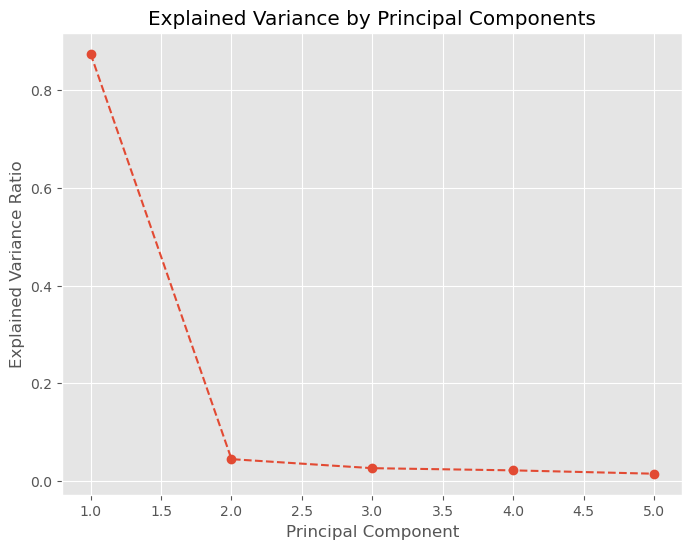

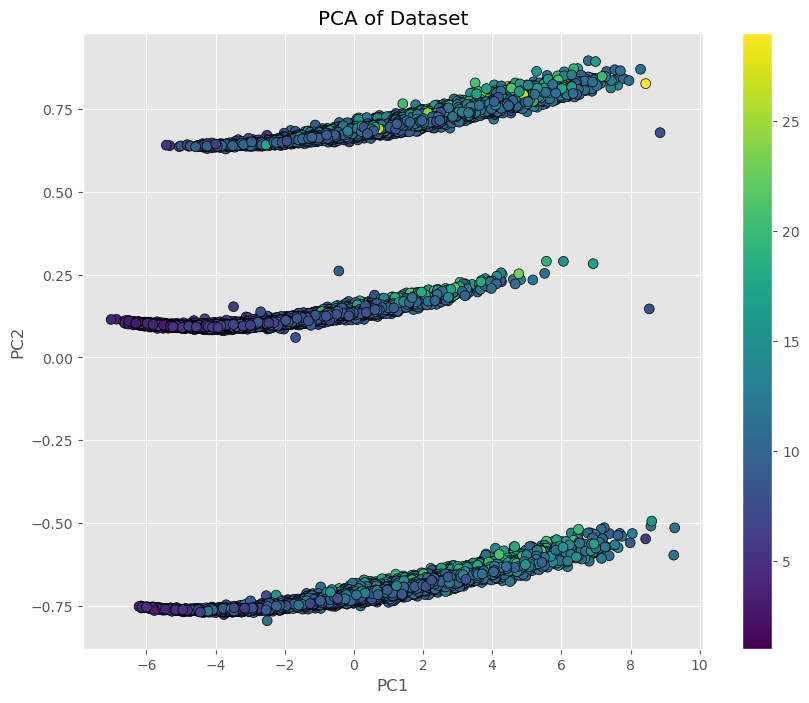

In [15]:
# PCA

# Calling the normalized data from the original dataset


# Perform PCA
pca_crab = PCA(n_components=5)
label_pca = pca_crab.fit_transform(X_pca)

# Explained variance ratio
explained_variance = pca_crab.explained_variance_ratio_

# plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
          marker = 'o', linestyle = '--')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')

plt.show()

# Scatterplot of the first two principal components
plt.figure(figsize=(10,8))
plt.scatter(label_pca.iloc[:, 0], label_pca.iloc[:, 1], c = y_pca, cmap = 'viridis', edgecolor = 'k', s = 50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.colorbar()

plt.show()

# display the transformed data
# print(pd.DataFrame(X_pca)) # show the values of all PC

In [16]:
components = pca_crab.components_
components = cupy.asarray(components)
loadings = cupy.abs(components)
feature_names = X_pca.columns.to_list()
print(components.shape)

feature_importance_df = cudf.DataFrame(loadings, index=[f'PC{i+1}' for i in range(components.shape[0])], columns=feature_names)

print(feature_names)
print(len(feature_names))

print(feature_importance_df)

(5, 10)
['num__length', 'num__diameter', 'num__height', 'num__weight', 'num__shucked_weight', 'num__viscera_weight', 'num__shell_weight', 'cat__sex_F', 'cat__sex_I', 'cat__sex_M']
10
     num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M
PC1     0.375801       0.376421     0.364145     0.380704             0.371055             0.374098           0.373311    0.064721    0.122551    0.057830
PC2     0.011349       0.009648     0.000925     0.015267             0.002973             0.020958           0.025091    0.648576    0.104368    0.752943
PC3     0.200279       0.214841     0.380313     0.268926             0.398911             0.282143           0.102919    0.341267    0.539924    0.198657
PC4     0.272629       0.261954     0.445322     0.170985             0.215212             0.233896           0.059711    0.350002    0.588018    0.238016
PC5     0.480208       0.433044     0.5382

In [17]:
print(label_pca.head(15))

           0         1         2         3         4
0   1.215727  0.159086  0.664522 -0.750220 -0.261634
1  -2.484867  0.103940  0.134212 -0.487214 -0.053463
2   0.577509 -0.714590 -0.268344  0.045605 -0.144470
3   4.933453  0.789274  0.562408  0.214968  0.523774
4  -0.306376  0.136864  0.698724 -0.453704 -0.111845
5   1.529107 -0.699190 -0.163505 -0.052588 -0.083226
6   1.406217 -0.689942  0.073044  0.237691 -0.323808
7  -0.663054  0.123408  0.151743 -0.853227 -0.095912
8   2.858058  0.728753  0.028382  0.090207 -0.045206
9  -2.627152 -0.752586 -0.480635  0.513003  0.048207
10 -3.582358  0.096646  0.286548 -0.108064 -0.080208
11 -0.416319  0.680240 -0.743751  0.078519  0.294481
12 -0.105031 -0.717838 -0.427063  0.066063  0.034660
13 -2.344266  0.103887  0.070746 -0.574636 -0.040356
14 -0.729344 -0.736278 -0.398502  0.195582 -0.321697


In [18]:
# split data 

columns = label_pca.columns.to_list()

for col in columns:
    label_pca[col] = label_pca[col].astype('float32')

y = cudf.to_numeric(y_pca, errors='coerce').astype('float32')

print(X_pca.dtypes) # final check
print(type(y))


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)


pca_compiled_scores = {}

num__length            float64
num__diameter          float64
num__height            float64
num__weight            float64
num__shucked_weight    float64
num__viscera_weight    float64
num__shell_weight      float64
cat__sex_F             float64
cat__sex_I             float64
cat__sex_M             float64
dtype: object
<class 'cudf.core.series.Series'>


In [19]:
## Linear Regression with PC


linreg_pca = LinearRegression(copy_X=True)

linreg_pca_model = linreg_pca.fit(X_train, y_train)

get_scores(linreg_pca, pca_compiled_scores)


    --------------------
    Performance Metrics: LinearRegression()
    --------------------
        
    Mean Absolute Error (train): 1.4809
    Mean Absolute Error (test): 1.4886

    --------------------------------------------------

    Mean Squared Error (train): 4.5324
    Mean Squared Error (test): 4.5151

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.5492
    Coefficient of Determination (R2) (test): 0.5570

    --------------------------------------------------

    


In [20]:
## Lasso Regression with PC

lasso_pca = Lasso(alpha = 0.5)

lasso_pca = lasso_pca.fit(X_train, y_train)

get_scores(lasso_pca, pca_compiled_scores)



    --------------------
    Performance Metrics: Lasso()
    --------------------
        
    Mean Absolute Error (train): 1.7230
    Mean Absolute Error (test): 1.7352

    --------------------------------------------------

    Mean Squared Error (train): 5.8150
    Mean Squared Error (test): 5.8749

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.4216
    Coefficient of Determination (R2) (test): 0.4236

    --------------------------------------------------

    


In [22]:
%%time
# Random Forest

rf_pca = RandomForestRegressor()
rf_pca_model = rf_pca.fit(X_train, y_train)

get_scores(rf_pca_model, pca_compiled_scores)

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)



    --------------------
    Performance Metrics: RandomForestRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.0147
    Mean Absolute Error (test): 1.4251

    --------------------------------------------------

    Mean Squared Error (train): 1.9957
    Mean Squared Error (test): 4.2518

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.8015
    Coefficient of Determination (R2) (test): 0.5828

    --------------------------------------------------

    
CPU times: user 9.1 s, sys: 2.18 s, total: 11.3 s
Wall time: 2.51 s


In [23]:
%%time

# K Nearest Neighbours
knn_pca = KNeighborsRegressor()

knn_pca_model = knn_pca.fit(X_train, y_train)

get_scores(knn_pca, pca_compiled_scores)


    --------------------
    Performance Metrics: KNeighborsRegressor()
    --------------------
        
    Mean Absolute Error (train): 1.2691
    Mean Absolute Error (test): 1.5430

    --------------------------------------------------

    Mean Squared Error (train): 3.3660
    Mean Squared Error (test): 5.0040

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6652
    Coefficient of Determination (R2) (test): 0.5090

    --------------------------------------------------

    
CPU times: user 268 ms, sys: 0 ns, total: 268 ms
Wall time: 274 ms


In [24]:
%%time

svr_pca = SVR()

svr_pca_model = svr_pca.fit(X_train, y_train)

get_scores(svr_pca_model, pca_compiled_scores)


    --------------------
    Performance Metrics: SVR()
    --------------------
        
    Mean Absolute Error (train): 1.3769
    Mean Absolute Error (test): 1.3821

    --------------------------------------------------

    Mean Squared Error (train): 4.3901
    Mean Squared Error (test): 4.3799

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.5634
    Coefficient of Determination (R2) (test): 0.5702

    --------------------------------------------------

    
CPU times: user 5.52 s, sys: 1.22 s, total: 6.74 s
Wall time: 6.84 s


In [28]:
%%time

# Catboost

cat_pca = CatBoostRegressor(task_type = 'GPU',
                        iterations = 1000,
                        learning_rate = 0.1,
                        verbose = False)

y_train_np = y_train.to_numpy()  # Convert cuDF Series to NumPy array

cat_pca_model = cat_pca.fit(X_train, y_train_np)

get_scores(cat_pca_model, pca_compiled_scores)


    --------------------
    Performance Metrics: <catboost.core.CatBoostRegressor object at 0x7fee545fb490>
    --------------------
        
    Mean Absolute Error (train): 1.3070
    Mean Absolute Error (test): 1.4066

    --------------------------------------------------

    Mean Squared Error (train): 3.5155
    Mean Squared Error (test): 4.1575

    --------------------------------------------------

    Coefficient of Determination (R2) (train): 0.6503
    Coefficient of Determination (R2) (test): 0.5921

    --------------------------------------------------

    
CPU times: user 11.5 s, sys: 3.74 s, total: 15.2 s
Wall time: 9.07 s


In [29]:
%%time

# XGBoost

xgb_pca_model = xgb.XGBRegressor(
            device = 'cuda',  # Using GPU
            booster = 'gbtree',
            random_state=42
            )

xgb_pca_model = xgb_pca_model.fit(X_train, y_train)

get_scores(xgb_pca_model, pca_compiled_scores)


    --------------------
    Performance Metrics: XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
    --------------------
        
    Mean Absolute Error (train): 1.2544
    Mean Absolute Error (test): 1.4219

    --------------------------------------------------

    Mean Squared Error (trai

/home/timjrchan/miniconda3/envs/rapids-24.06/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [01:47:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1717021965948/work/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [31]:
pca_compiled_scores_df = pd.DataFrame(pca_compiled_scores)

list_of_models = ['Linear Regression', 'Lasso Regression', 'Random Forest', 'K-Nearest Neighbours',
                  'Support Vector Machine', 'Catboost', 'XGBoost']

# rename the name of models in df
pca_compiled_scores_df.columns = list_of_models[:len(pca_compiled_scores_df.columns)]

print(pca_compiled_scores_df)
    

           Linear Regression  Lasso Regression  Random Forest  K-Nearest Neighbours  Support Vector Machine  Catboost   XGBoost
MAE Train           1.480879          1.722958       1.014737              1.269082                1.376891  1.306964  1.254417
MAE Test            1.488617          1.735240       1.425078              1.542975                1.382107  1.406616  1.421909
MSE Train           4.532355          5.814952       1.995655              3.366018                4.390131  3.515494  3.223842
MSE Test            4.515056          5.874862       4.251776              5.004041                4.379922  4.157457  4.274100
R2 Train            0.549207          0.421639       0.801510              0.665213                0.563353  0.650345  0.679353
R2 Test             0.556981          0.423557       0.582814              0.509002                0.570240  0.592069  0.580624


### END-OF-GPU-PCA
---

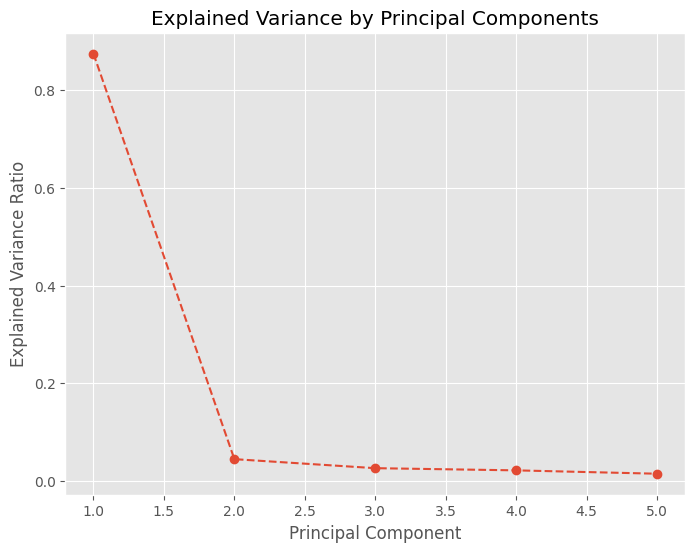

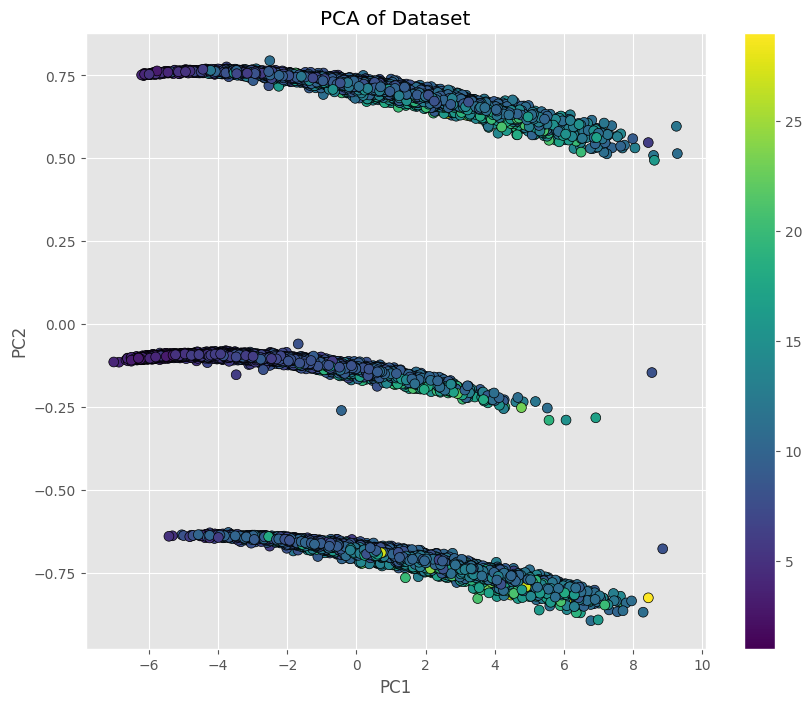

In [64]:
# PCA


# Seperating the target and response variables
y = scaled_df['age'] # target variable
X = scaled_df.iloc[:, :-1] # independent variable

# Perform PCA
pca_crab = PCA(n_components=5)
X_pca = pca_crab.fit_transform(X)

# Explained variance ratio
explained_variance = pca_crab.explained_variance_ratio_

# plot the explained variance
plt.figure(figsize=(8,6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance,
          marker = 'o', linestyle = '--')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')

plt.show()

# Scatterplot of the first two principal components
plt.figure(figsize=(10,8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'viridis', edgecolor = 'k', s = 50)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of Dataset')
plt.colorbar()

plt.show()

# display the transformed data
# print(pd.DataFrame(X_pca)) # show the values of all PC

In [18]:
print(feature_names)
print(len(feature_names))

NameError: name 'feature_names' is not defined

In [66]:
components = pca_crab.components_
loadings = np.abs(components)
feature_names = X.columns.to_list()
print(components.shape)

feature_importance_df = pd.DataFrame(loadings, index=[f'PC{i+1}' for i in range(components.shape[0])], columns=feature_names)

(5, 10)


In [67]:
print(feature_importance_df)

     num__length  num__diameter  num__height  num__weight  num__shucked_weight  num__viscera_weight  num__shell_weight  cat__sex_F  cat__sex_I  cat__sex_M
PC1     0.375801       0.376421     0.364145     0.380704             0.371055             0.374098           0.373311    0.064721    0.122551    0.057830
PC2     0.011349       0.009648     0.000925     0.015267             0.002973             0.020958           0.025091    0.648576    0.104368    0.752943
PC3     0.200279       0.214841     0.380313     0.268926             0.398911             0.282143           0.102919    0.341267    0.539924    0.198657
PC4     0.272629       0.261954     0.445322     0.170985             0.215212             0.233896           0.059711    0.350002    0.588018    0.238016
PC5     0.480208       0.433044     0.538286     0.090943             0.243852             0.088464           0.464090    0.027980    0.015720    0.012261


### Linear Regression with PCA


In [68]:
# using helpers to get cv results

linreg = LinearRegression()

linreg_pca = helpers.get_cv_results(linreg, X_pca, y,5)

print(linreg_pca)

Cross Validation Results:
fit_time [0.01837301 0.00449085 0.00730109 0.0045259  0.00440502]
score_time [0.00224996 0.00296617 0.0019269  0.00062203 0.00063109]
test_neg_mean_absolute_error [-1.57832921 -1.60054292 -1.57639885 -1.59455539 -1.58413189]
train_neg_mean_absolute_error [-1.58913208 -1.58193795 -1.58965196 -1.58407778 -1.58868802]
test_neg_mean_squared_error [-5.09958079 -5.38275332 -5.05444166 -5.39571482 -5.10840605]
train_neg_mean_squared_error [-5.22905012 -5.15894657 -5.24089676 -5.15572948 -5.22703609]
test_r2 [0.4916586  0.47347461 0.49620498 0.4699074  0.48614425]
train_r2 [0.48197268 0.48648238 0.48078688 0.48736677 0.48332584]
None


In [69]:
xgb_model = xgb.XGBRegressor()


xgb_pca = helpers.get_cv_results(xgb_model, X_pca, y, 5)

print(xgb_pca)

KeyboardInterrupt: 

## Without Addressing Multicollinearity

#### Linear Regression

In [ ]:
# Fit Linear Regression

linreg = LinearRegression()
linreg_model = linreg.fit(X_pca, y)

lin_reg_cv = helpers.get_cv_results(linreg_model, X, y, 5)


Cross Validation Results:
fit_time [0.007658   0.00763392 0.00648499 0.00822282 0.010077  ]
score_time [0.00135994 0.00121808 0.00105715 0.0011692  0.00179696]
test_neg_mean_absolute_error [-1.47402493 -1.49101239 -1.46569384 -1.49755124 -1.48386011]
train_neg_mean_absolute_error [-1.48501352 -1.47994682 -1.48551906 -1.47837694 -1.48208908]
test_neg_mean_squared_error [-4.49574569 -4.57531402 -4.4214374  -4.66123975 -4.49847563]
train_neg_mean_squared_error [-4.53736852 -4.51706078 -4.55543444 -4.49543106 -4.53621669]
test_r2 [0.55185068 0.55245599 0.55929887 0.54206462 0.5474973 ]
train_r2 [0.55049563 0.55037521 0.5486953  0.55302012 0.55161091]


Looking at the cross validations scores from Linear Regression Model, we can see that the values of MAE and MSE are relatively close to each other. 

However, the R2 value only shows that the model is able to predict about 55% of the variation. It is likely that the model assumption for linear regression is broken. 

#### Lasso Regression

In [ ]:
# Lasso regression

lasso = Lasso(alpha = 0.5)

lasso_model = lasso.fit(X_pca, y)

lasso_model_results = helpers.get_cv_results(lasso_model, X_pca, y, 5)

print(lasso_model_results)

Cross Validation Results:
fit_time [0.04859996 0.00485516 0.00296497 0.00220895 0.00246119]
score_time [0.00099397 0.00457788 0.00078082 0.00061488 0.00121593]
test_neg_mean_absolute_error [-1.74932875 -1.78789667 -1.76099988 -1.77444994 -1.7709473 ]
train_neg_mean_absolute_error [-1.77510828 -1.76270605 -1.76986773 -1.7668473  -1.76895582]
test_neg_mean_squared_error [-6.04388133 -6.26478257 -6.14912317 -6.2738449  -6.13926303]
train_neg_mean_squared_error [-6.20782053 -6.15361483 -6.17788631 -6.15050048 -6.17940486]
test_r2 [0.39752791 0.38719705 0.387094   0.38363704 0.38245011]
train_r2 [0.38500864 0.38747386 0.38795978 0.38845688 0.38918753]
None


#### Random Forest

In [ ]:
# Random Forest

rf = RandomForestRegressor()
rf_model = rf.fit(X_pca, y)

rf_model_results = helpers.get_cv_results(rf_model, X_pca, y ,5)

print(rf_model_results)

Cross Validation Results:
fit_time [26.12770271 25.76700997 25.82509208 25.71733093 25.86681008]
score_time [0.30813909 0.30446172 0.29995012 0.29886794 0.30065107]
test_neg_mean_absolute_error [-1.53021133 -1.55219379 -1.53583592 -1.54844159 -1.54411479]
train_neg_mean_absolute_error [-0.57572248 -0.57170507 -0.57340828 -0.57094597 -0.57418004]
test_neg_mean_squared_error [-4.84332176 -4.99324491 -4.86770469 -4.97162134 -4.91411523]
train_neg_mean_squared_error [-0.69250208 -0.6850251  -0.69001341 -0.68483351 -0.69215425]
test_r2 [0.51720326 0.5115752  0.51481775 0.51157172 0.50568801]
train_r2 [0.93139576 0.93181312 0.9316407  0.93190713 0.93158298]
None


#### K-Nearest Neighbours

In [ ]:
# KNN

knn = KNeighborsRegressor()
knn_model = knn.fit(X_pca, y)

knn_model_results = helpers.get_cv_results(knn_model, X_pca, y, 5)

print(knn_model_results)

Cross Validation Results:
fit_time [0.01484513 0.01405478 0.01349282 0.01485109 0.01583409]
score_time [0.05680299 0.06248403 0.0568831  0.06036186 0.05614161]
test_neg_mean_absolute_error [-1.64843697 -1.67309926 -1.64735989 -1.66686023 -1.64997974]
train_neg_mean_absolute_error [-1.35889939 -1.34647626 -1.35306291 -1.35191843 -1.35315069]
test_neg_mean_squared_error [-5.59563838 -5.74926941 -5.59891155 -5.72930452 -5.64375152]
train_neg_mean_squared_error [-3.81016475 -3.75090427 -3.78235614 -3.77295792 -3.77862629]
test_r2 [0.4422101  0.43762306 0.44193564 0.43713446 0.43229373]
train_r2 [0.62253767 0.62663784 0.6252838  0.62485549 0.62649606]
None


#### Support Vector Regressor (SVM)

In [ ]:
# SVR

svr = SVR()
svr_model = svr.fit(X_pca, y)

svr_model_results = helpers.get_cv_results(svr_model, X_pca, y, 5)

print(svr_model_results)

Cross Validation Results:
fit_time [54.27167797 53.91730785 54.72106099 54.65533686 55.43706012]
score_time [25.04787493 25.02699208 25.26538301 25.31194115 25.61884069]
test_neg_mean_absolute_error [-1.46273506 -1.49316244 -1.45907184 -1.47903497 -1.47494596]
train_neg_mean_absolute_error [-1.47410762 -1.46653347 -1.47497032 -1.4702581  -1.47083017]
test_neg_mean_squared_error [-5.04596233 -5.20670965 -4.98967849 -5.17021599 -5.07891582]
train_neg_mean_squared_error [-5.09984309 -5.0719914  -5.10654631 -5.07569469 -5.08636433]
test_r2 [0.49700345 0.49069469 0.50266016 0.49206114 0.48911068]
train_r2 [0.49477286 0.49513783 0.49409691 0.49532462 0.49723074]
None


#### Polynomial Regression

In [ ]:
# Polynomial regression

poly = PolynomialFeatures(degree = 2)

X_poly = poly.fit_transform(X_pca)

linreg2 = LinearRegression()

linreg2_model = linreg2.fit(X_poly,y)

linreg2_model_results = helpers.get_cv_results(linreg2, X_pca, y, 5)

print(linreg2_model_results)

Cross Validation Results:
fit_time [0.00513411 0.00438094 0.00422621 0.00484014 0.00429916]
score_time [0.00122285 0.00067401 0.00065088 0.00113297 0.00064397]
test_neg_mean_absolute_error [-1.57832921 -1.60054292 -1.57639885 -1.59455539 -1.58413189]
train_neg_mean_absolute_error [-1.58913208 -1.58193795 -1.58965196 -1.58407778 -1.58868802]
test_neg_mean_squared_error [-5.09958079 -5.38275332 -5.05444166 -5.39571482 -5.10840605]
train_neg_mean_squared_error [-5.22905012 -5.15894657 -5.24089676 -5.15572948 -5.22703609]
test_r2 [0.4916586  0.47347461 0.49620498 0.4699074  0.48614425]
train_r2 [0.48197268 0.48648238 0.48078688 0.48736677 0.48332584]
None


#### XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor()

cv_results = helpers.get_cv_results(xgb_model, X, y, 5)

Cross Validation Results:
fit_time [0.27741098 0.19475031 0.16631889 0.14856505 0.15819788]
score_time [0.00693893 0.00556588 0.00581336 0.00571799 0.00787306]
test_neg_mean_absolute_error [-1.41469005 -1.42097167 -1.40928411 -1.4318559  -1.42525562]
train_neg_mean_absolute_error [-1.25630621 -1.2558969  -1.26195309 -1.25189227 -1.25302246]
test_neg_mean_squared_error [-4.30115113 -4.30425002 -4.22842024 -4.35225103 -4.29872033]
train_neg_mean_squared_error [-3.23069295 -3.24163705 -3.27716427 -3.21106399 -3.22181742]
test_r2 [0.57124841 0.57897067 0.57853764 0.57242072 0.56759071]
train_r2 [0.67994434 0.6773299  0.6753329  0.6807245  0.68153459]


#### CatBoost

In [ ]:
from catboost import CatBoostRegressor

cat = CatBoostRegressor(verbose=False)

cat_model = cat.fit(X_pca, y)

cat_model_results = helpers.get_cv_results(cat_model, X_pca, y, 5)

print(cat_model)

Cross Validation Results:
fit_time [6.36401558 6.53583241 6.68344283 6.80572009 6.9684875 ]
score_time [0.03667092 0.03124285 0.03124213 0.03124547 0.03666687]
test_neg_mean_absolute_error [-1.46802084 -1.49374689 -1.47337828 -1.48845827 -1.48940733]
train_neg_mean_absolute_error [-1.40285797 -1.39705283 -1.40308373 -1.39767049 -1.4032486 ]
test_neg_mean_squared_error [-4.55139392 -4.69920106 -4.55274815 -4.69692873 -4.68146923]
train_neg_mean_squared_error [-4.05172574 -4.02568625 -4.05679514 -4.0210453  -4.04780938]
test_r2 [0.5463035  0.54033772 0.54621064 0.53855842 0.52908993]
train_r2 [0.5986069  0.59928625 0.59809526 0.60018821 0.59988825]


#### Light Gradient-Boosting Machine (lightgbm)

In [ ]:
print(type(X_pca))

<class 'numpy.ndarray'>


In [ ]:
import lightgbm as lgb

# Convert Series to Dataset



lgb_train_data = lgb.Dataset(X_pca, label = y)

# specify parameters
params = {
    'objective' : 'regression',
    'metric': ['mse', 'mae'],
    'verbosity': -1,
    'device': 'gpu' 

}


cv_results = lgb.cv(params, lgb_train_data, num_boost_round=100, nfold=5)

for k, v in cv_results.items():
    print(k,np.mean(v))



valid l2-mean 5.011107527957214
valid l2-stdv 0.03260963401394465
valid l1-mean 1.5548000481979383
valid l1-stdv 0.0038807136026509804
